## ENHANCING STORE SALES PREDICTION FOR FAVORITA.

## 1. BUSINESS UNDERSTANDING
Corporation Favorita is a significant actor in Ecuador's dynamic economic environment and contributes to the country's economic diversification as a result of the country's strong reliance on oil prices. Favorita, a complex Ecuadorian business, operates both inside and outside of national borders and makes investments in a range of industries to support economic resilience.

Corporation Favorita is aware of the crucial necessity for well-informed decision-making in its pursuit of sustainable growth and economic stability. In order to achieve this, the company aims to maximize the potential of data-driven insights, particularly with regard to its grocery retail operations. Favorita intends to bolster its market presence, optimize its offers, and contribute to the resiliency of the country's economy by diving into the complex patterns of retail sales, product dynamics, and transaction behaviors.


### Problem Statement
The inconsistent and unpredictable nature of sales across various stores and product categories is the issue that we seek to solve. Our capacity to make data-driven decisions in inventory management and personnel is hampered by the variability of the sales data. We want to estimate in-store sales precisely by creating an accurate regression model, which will enhance inventory management, lessen stockouts and overstocking, and eventually increase income potential. When this predictive model is successfully implemented, store operations, customer satisfaction, and overall business performance will all be improved.

## Objectives of the Project.
1.  Investigate the performance variations across different Favorita stores.
2. Create reliable time series forecasting models that can accurately anticipate unit sales for the wide range of products sold in different Favorita stores.
3. Assess the impact of promotional strategies on sales. By analyzing the correlation between promotions and sales spikes, the project aims to determine the efficacy of different promotional tactics and optimize their deployment.
4. Conduct a comprehensive analysis of annual transaction volumes, trends, and variations.

## 2. DATA COLLECTION AND DATA PREPARATION

    2.1 DATA COLLECTION

Installations and Importing the necessary libraries

In [258]:
#Install pyodbc and python-dotenv
%pip install pyodbc  
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [259]:
#Importing the necessary Libraries.
#Libraries to collect and manipulate data-cleaning
import pyodbc                    #
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import os,pickle
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
import missingno as msno
import zipfile
import warnings 
warnings.filterwarnings('ignore')

#Libraries for Vizualization and EDA
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display
# EDA (pandas-profiling, etc. )
#import ydata_profiling as pp


#Modelling Libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,MinMaxScaler
#from sklearn.impute import SimpleImputerr
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_squared_log_error
import statsmodels.api as sm
from scipy.sparse import csc_matrix
from sklearn.model_selection import GridSearchCV, KFold
#Time Series EXploration Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import random
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

### Data Loading
Here we are going to load all our datasets from dapDB and  read the other data files provided. We will passing in the parse dates and reindex the dates column to easen our analysis

I. datasets from DB

These are oil, stores and holiday/event datasets

In [260]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")


connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [261]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection=pyodbc.connect(connection_string)

In [262]:
#Getting the 3 datasets and creating a dataframe names for the 3.
query="Select * from dbo.oil"
data_oil=pd.read_sql(query,connection,index_col = 'date',parse_dates =True)
query="Select * from dbo.holidays_events"
data_events=pd.read_sql(query,connection,index_col ='date',parse_dates =True)
query="Select * from dbo.stores"
data_stores=pd.read_sql(query,connection)

II. Loading the csv files datasets. 

These are the test, Sample Submission in CSV form and the train an transactions stored in a zipfile


In [263]:
# using pandas to load datasets stored as CSV
data_submission = pd.read_csv('sample_submission.csv')
data_test = pd.read_csv('test.csv',index_col = 'date',parse_dates =True)


In [264]:
# Specify the ZIP file path
zip_file_path = 'store-sales-forecasting.zip'

# Initialize the ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    # Read the 'train.csv' file from the ZIP archive
    with zip_ref.open('train.csv') as train:
        data_train = pd.read_csv(train,index_col = 'date',parse_dates =True)

    # Read the 'transactions.csv' file from the ZIP archive
    with zip_ref.open('transactions.csv') as transactions:
        data_transaction = pd.read_csv(transactions,index_col = 'date',parse_dates =True)

##### 2.2 DATA PREPARATION AND PROCESSING

In this we are going to prepare our data by exploring, cleaning and preparing for analysis and modeling
The datasets are stored in these dataframes: 
- Main datasets for project: **data_train and data_test**
- Supplementary datasets: **data_transaction, data_oil, data_events, data_stores and data_submission**

##### 2.2.1. Previewing the datasets and formulate hypothesis and questions to be used for analysis

- *train dataset previewing*

In [265]:
#check features of the train dataset
data_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [266]:
#shape of the df-train
data_train.shape

(3000888, 5)

In [267]:
#check data infor
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


The train dataset has 6 columns - **with date column reindex**,  one categorical and 4 numerical and 300088 rows/entries

In [268]:
#check the columns
data_train.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

- *previewing Test dataset*

In [501]:
##check features of the test dataset
data_test.tail()

,date,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name
28507,2017-08-31,3029395,9,POULTRY,1,2017,8,Thursday
28508,2017-08-31,3029396,9,PREPARED FOODS,0,2017,8,Thursday
28509,2017-08-31,3029397,9,PRODUCE,1,2017,8,Thursday
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,Thursday
28511,2017-08-31,3029399,9,SEAFOOD,0,2017,8,Thursday


In [270]:
#shape on test data
data_test.shape

(28512, 4)

In [271]:
#check data infor
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [272]:
data_test.columns

Index(['id', 'store_nbr', 'family', 'onpromotion'], dtype='object')

From the info data, test dataset has 5 columns - **with date column reindexed**, 1 categorical and 3 numerical - **missing the sales column** and  28512 rows/entries

- *transactions dataset previewing*

In [502]:
#check features of the transaction dataset
data_transaction.tail()

,date,Store_nbr,Transaction
83483,2017-08-15,50.0,2804.0
83484,2017-08-15,51.0,1573.0
83485,2017-08-15,52.0,2255.0
83486,2017-08-15,53.0,932.0
83487,2017-08-15,54.0,802.0


In [274]:
#shape on transaction data
data_transaction.shape

(83488, 2)

In [275]:
#check data infor
data_transaction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [276]:
#rechecking columns
data_transaction.columns

Index(['store_nbr', 'transactions'], dtype='object')

The Transaction dataset has  3 columns - **with date column reindex** and 2 numerical columns and 83488 rows/entries

- *Previewing the Store dataset*

In [277]:
#check features of the store dataset
data_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [278]:
#shape on store data
data_stores.shape

(54, 5)

In [279]:
#check data infor
data_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [280]:
#rechecking columns
data_stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

The stores dataset have: 5 columns(3 categorical and 2 numerical) and 54 rows/entries. showing locations and store numbers and the how many clusters each store has.

- *Previewing the holiday/events dataset*

In [503]:
#check features of the event dataset
data_events.tail()

,date,Type,Locale,Locale_Name,Description,Transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [282]:
#shape on event data
data_events.shape

(350, 5)

In [283]:
#check data infor
data_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


In [284]:
#rechecking columns
data_events.columns

Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

The Holiday/event dataset has  6 columns - **with date column reindex** ,3 categorical and one boolen and 350 rows/entries

- *Previewing the Oil dataset*

In [285]:
#check features of the oil dataset
data_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [286]:
#shape on oil data
data_oil.shape

(1218, 1)

In [287]:
#check data infor
data_oil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0+ KB


In [288]:
#rechecking columns
data_oil.columns

Index(['dcoilwtico'], dtype='object')

The Oil dataset has  2 columns - **with date column reindex** and 1 numerical columns and 1218 rows/entries

## <u>Hypothesis Formulation</u>
Null Hypothesis(HO): There is no significant relationship between stores and transaction in  Ecuadorian-based grocery retailer.

Alternative Hypothesis(H1): There is a significant relationship between stores and transactions in  Ecuadorian-based grocery retailer.

<u>**Required Questions**</u>
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

3. Are certain groups of stores selling more products? (Cluster, city, state, type)

4. Are sales affected by promotions, oil prices and holidays?

5. What analysis can we get from the date and its extractable features?

6. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


### 2.2.2 <u>Data Cleaning </u>

Here we going to check for null values, impute null values and check for duplicates on each datasets in preparation for EDA analysis

- Cleaning Train Data

In [289]:
#check the dataframe
data_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [290]:
#Checking duplicated data
data_train.duplicated().sum()

0

we have no duplicates lets check the null values

In [291]:
#checking null values
data_train.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

<Axes: >

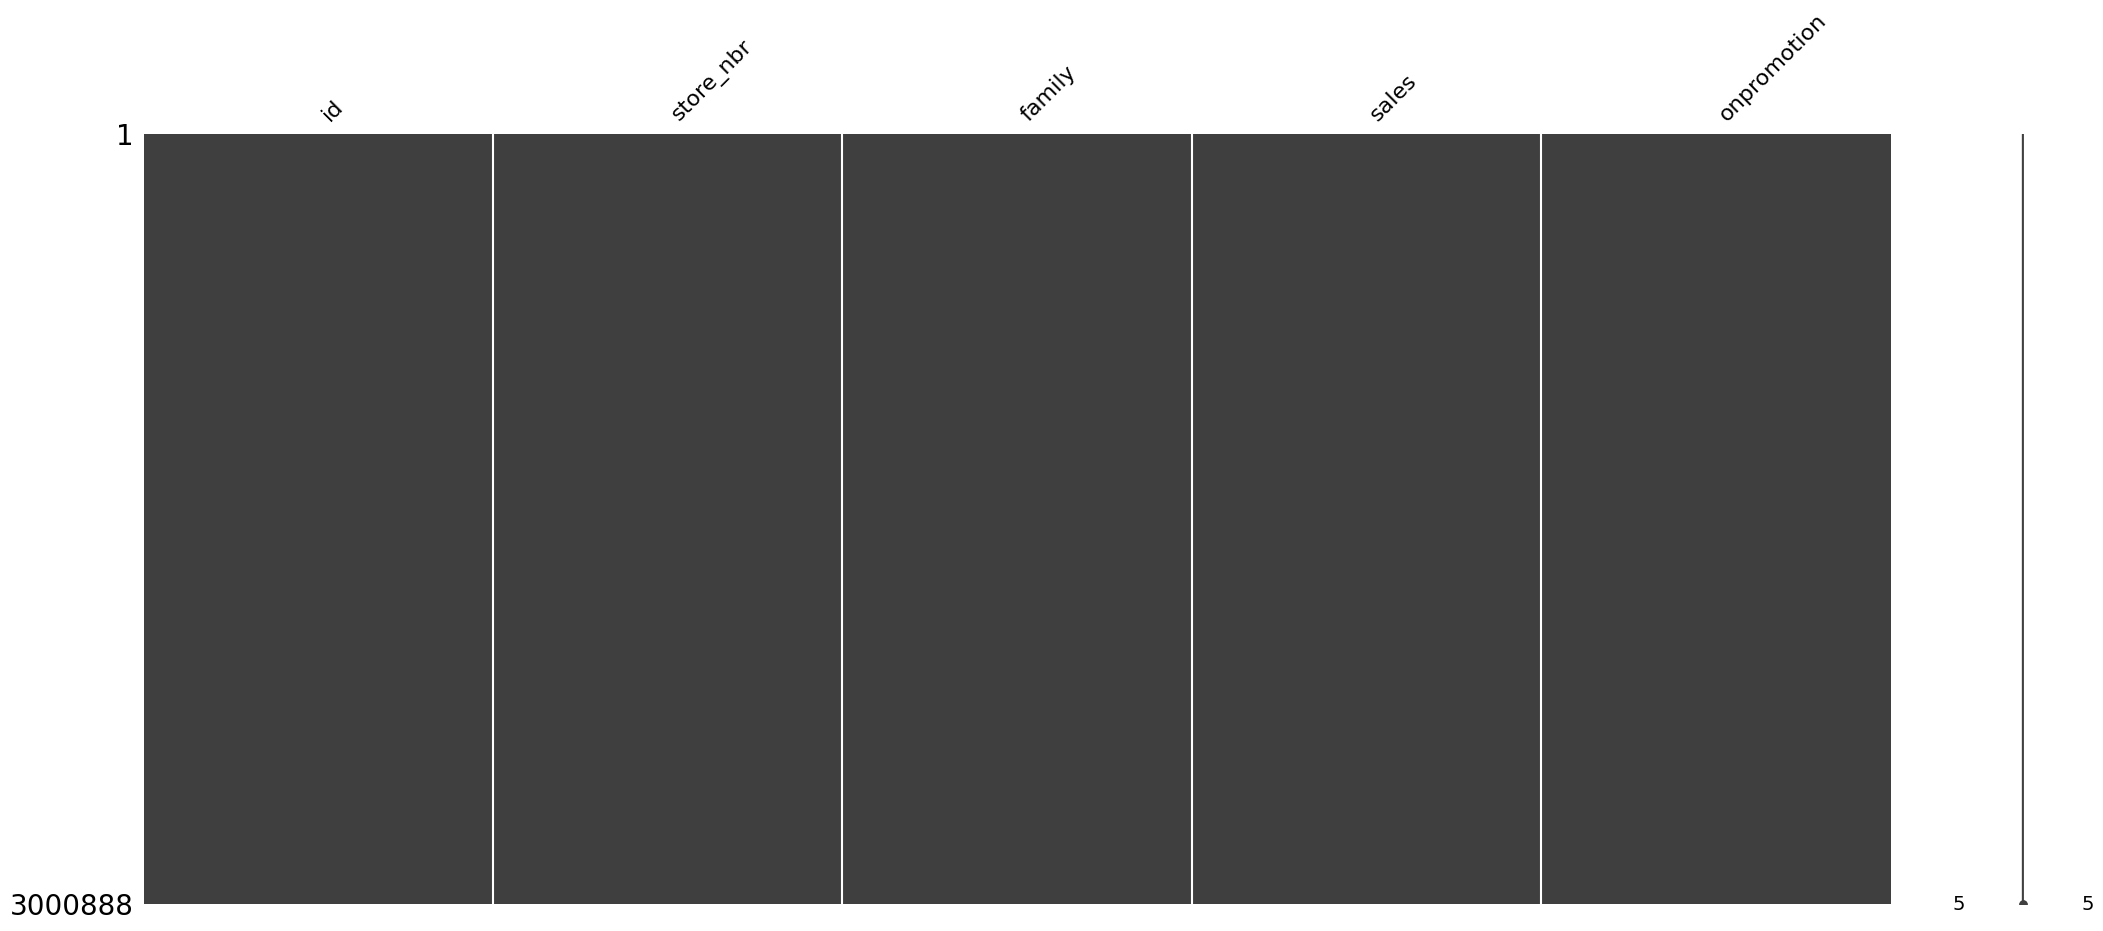

In [292]:
#visualizing missing data in a dataset. using msno.matrix
msno.matrix(data_train)

There are no missing values, lets check the datatypes for the columns and statistical description of the data

In [293]:
data_train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3000888.0,NaN,NaN,NaN,1500443.5,866281.891642,0.0,750221.75,1500443.5,2250665.25,3000887.0
store_nbr,3000888.0,NaN,NaN,NaN,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,357.775749,1101.997721,0.0,0.0,11.0,195.84725,124717.0
onpromotion,3000888.0,NaN,NaN,NaN,2.60277,12.218882,0.0,0.0,0.0,0.0,741.0


From the Statistical description: The most frequent family is Automotive occuring in 90936 times while the other varibales(ID, storenumber,sales and on promotion have 0 as entry as most frequent, NaN) 

In [294]:
data_train.dtypes

id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [295]:
#lets convert all numeric columns to numeric using pandas and recheck missing values
data_train['sales'] = pd.to_numeric(data_train['sales'], errors='coerce')
data_train['store_nbr'] = pd.to_numeric(data_train['store_nbr'], errors='coerce')
data_train['onpromotion'] = pd.to_numeric(data_train['onpromotion'], errors='coerce')

In [296]:
data_train.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

No null values even after converting all numeric columns to pandas numeric. 
Lets now create new features - year, month and day name for the date column.

In [297]:
#By use pandas lets create a time series
data_train['Year'] = data_train.index.year
data_train['Month'] = data_train.index.month
data_train['WeekDay Name'] = data_train.index.day_name()

#Show the dataframe part of dataframe using .head()
data_train.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,WeekDay Name
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,2013,1,Tuesday


In [298]:
#Lets now rearrange and rename the rows.
# Rename the columns
data_train = data_train.rename(columns={
    'id': 'ID',
    'store_nbr': 'Store_nbr',
    'family': 'Family',
    'sales': 'Sales($)',
    'onpromotion': 'Onpromotion',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name'
})

In [299]:
#rearrange 
# Define the new column order
new_column_order = ['ID', 'Store_nbr', 'Family', 'Onpromotion', 'Year', 'Month', 'Weekday Name', 'Sales($)']

# Rename and rearrange the columns
data_train = data_train[new_column_order]

# Show the DataFrame with the renamed and rearranged columns using .head()
data_train.head()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0,2013,1,Tuesday,0.0
2013-01-01,1,1,BABY CARE,0,2013,1,Tuesday,0.0
2013-01-01,2,1,BEAUTY,0,2013,1,Tuesday,0.0
2013-01-01,3,1,BEVERAGES,0,2013,1,Tuesday,0.0
2013-01-01,4,1,BOOKS,0,2013,1,Tuesday,0.0


The final cleaned Train Data

In [300]:
#the final dataframe: 
data_train.head()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0,2013,1,Tuesday,0.0
2013-01-01,1,1,BABY CARE,0,2013,1,Tuesday,0.0
2013-01-01,2,1,BEAUTY,0,2013,1,Tuesday,0.0
2013-01-01,3,1,BEVERAGES,0,2013,1,Tuesday,0.0
2013-01-01,4,1,BOOKS,0,2013,1,Tuesday,0.0


- Cleaning the Test Data

In [301]:
#check the dataframe
data_test.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [302]:
#Checking duplicated data
data_test.duplicated().sum()

0

We have no duplicates in the test datasets

In [303]:
#checking null values
data_test.isnull().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

<Axes: >

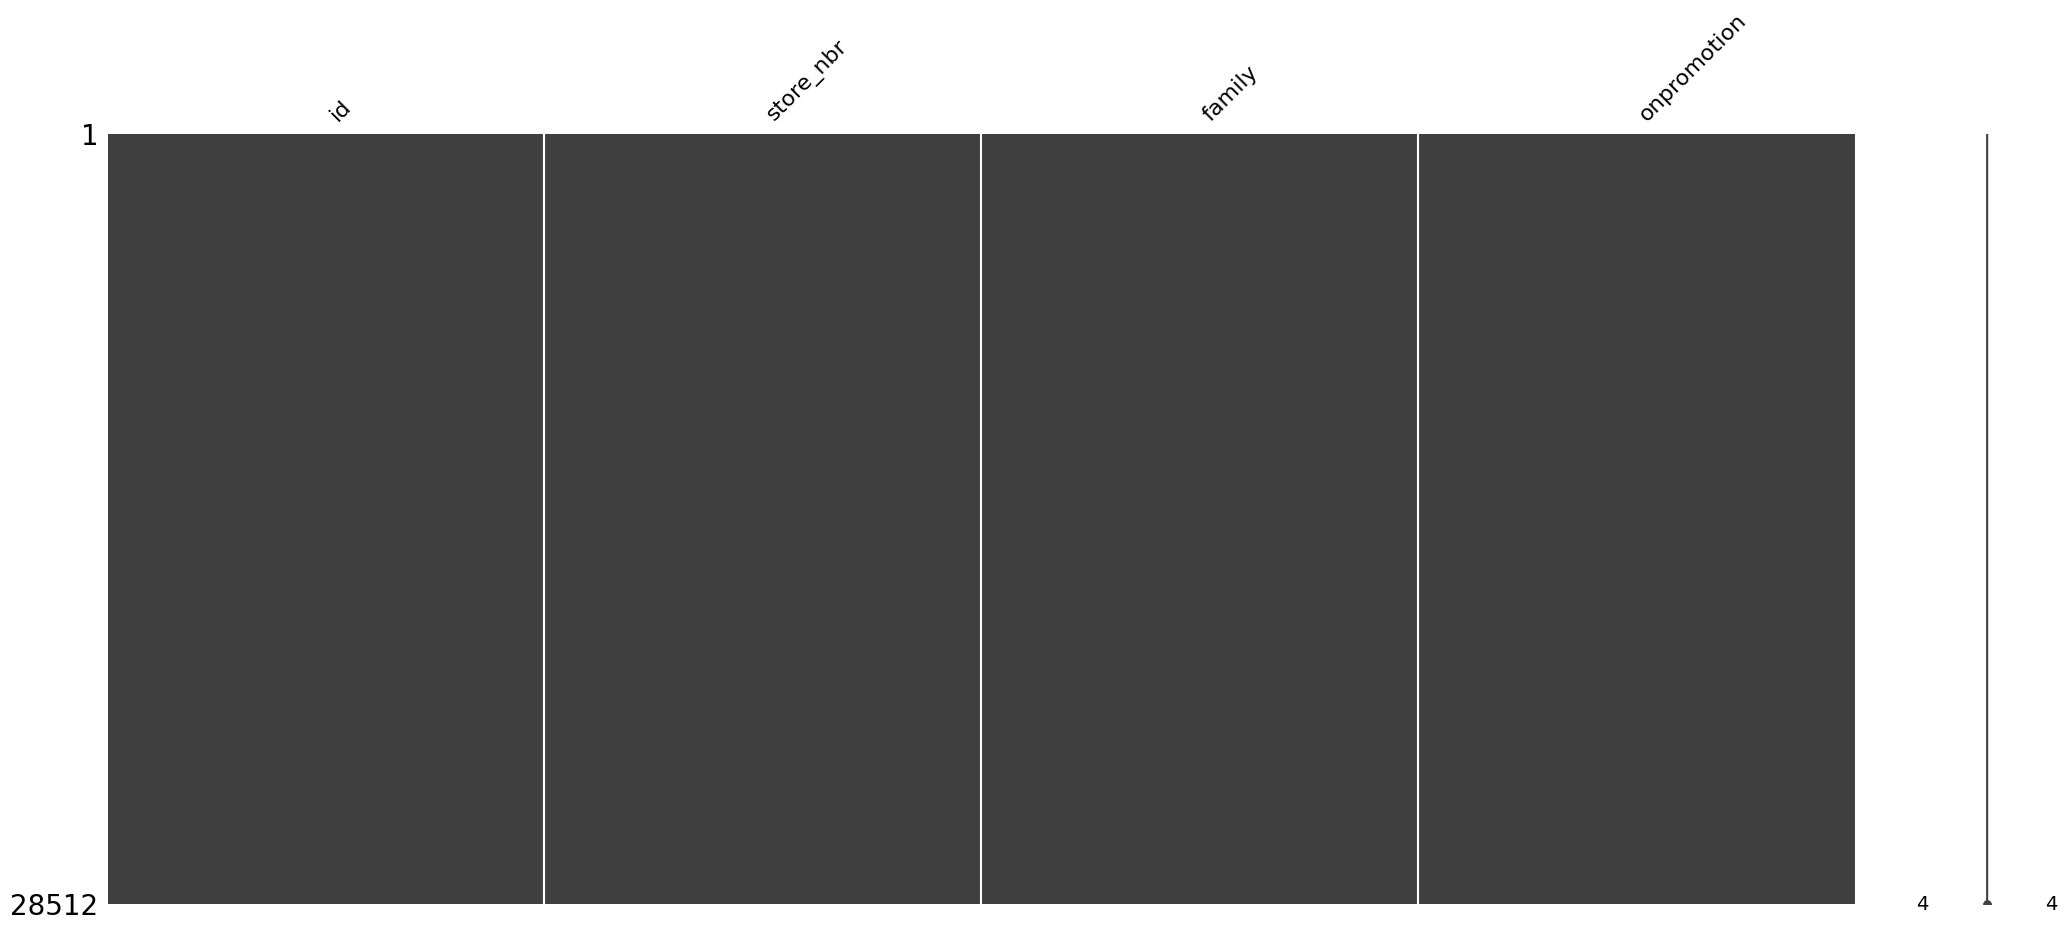

In [304]:
#visualizing missing data in a dataset. using msno.matrix
msno.matrix(data_test)

There are no missing values, lets check the  statistical description of the data

In [305]:
data_test.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,28512.0,NaN,NaN,NaN,3015143.5,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
store_nbr,28512.0,NaN,NaN,NaN,27.5,15.586057,1.0,14.0,27.5,41.0,54.0
family,28512,33,AUTOMOTIVE,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onpromotion,28512.0,NaN,NaN,NaN,6.965383,20.683952,0.0,0.0,0.0,6.0,646.0


From the Statistical description: The most frequent family is Automotive occuring in 864 times while the other varibales(ID, storenumber,and on promotion have 0 as the entry as the most frequent, NaN)

In [306]:
data_test.dtypes

id              int64
store_nbr       int64
family         object
onpromotion     int64
dtype: object

In [307]:
#lets convert all numeric columns to numeric using pandas and recheck missing values
data_test['store_nbr'] = pd.to_numeric(data_test['store_nbr'], errors='coerce')
data_test['onpromotion'] = pd.to_numeric(data_test['onpromotion'], errors='coerce')

In [308]:
data_test.isnull().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

No null values even after converting all numeric columns to pandas numeric. 
Lets now create new features - year, month and day name for the date column.

In [309]:
#By use pandas lets create a time series
data_test['Year'] = data_test.index.year
data_test['Month'] = data_test.index.month
data_test['WeekDay Name'] = data_test.index.day_name()

#Show the dataframe part of dataframe using .head()
data_test.head()

,id,store_nbr,family,onpromotion,Year,Month,WeekDay Name
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2017,8,Wednesday
2017-08-16,3000889,1,BABY CARE,0,2017,8,Wednesday
2017-08-16,3000890,1,BEAUTY,2,2017,8,Wednesday
2017-08-16,3000891,1,BEVERAGES,20,2017,8,Wednesday
2017-08-16,3000892,1,BOOKS,0,2017,8,Wednesday


In [310]:
#Lets now rearrange and rename the rows.
# Rename the columns
data_test = data_test.rename(columns={
    'id': 'ID',
    'store_nbr': 'Store_nbr',
    'family': 'Family',
    'onpromotion': 'Onpromotion',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name'
})

In [311]:
#rearrange 
# Define the new column order
new_col_order = ['ID', 'Store_nbr', 'Family', 'Onpromotion', 'Year', 'Month', 'Weekday Name']

# Rename and rearrange the columns
data_test = data_test[new_col_order]

# Show the DataFrame with the renamed and rearranged columns using .head()
data_test.head()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2017,8,Wednesday
2017-08-16,3000889,1,BABY CARE,0,2017,8,Wednesday
2017-08-16,3000890,1,BEAUTY,2,2017,8,Wednesday
2017-08-16,3000891,1,BEVERAGES,20,2017,8,Wednesday
2017-08-16,3000892,1,BOOKS,0,2017,8,Wednesday


The final cleaned Test data

In [312]:
data_test.head(10)

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2017,8,Wednesday
2017-08-16,3000889,1,BABY CARE,0,2017,8,Wednesday
2017-08-16,3000890,1,BEAUTY,2,2017,8,Wednesday
2017-08-16,3000891,1,BEVERAGES,20,2017,8,Wednesday
2017-08-16,3000892,1,BOOKS,0,2017,8,Wednesday
2017-08-16,3000893,1,BREAD/BAKERY,12,2017,8,Wednesday
2017-08-16,3000894,1,CELEBRATION,0,2017,8,Wednesday
2017-08-16,3000895,1,CLEANING,25,2017,8,Wednesday
2017-08-16,3000896,1,DAIRY,45,2017,8,Wednesday


- Cleaning the transactions dataset

In [313]:
#check the dataframe
data_transaction.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [314]:
# Find and display duplicated rows in the DataFrame
duplicated_rows = data_transaction[data_transaction.duplicated()]
print(duplicated_rows)

            store_nbr  transactions
date                               
2013-01-04         26           813
2013-01-04         30           689
2013-01-08         13           879
2013-01-09         51          1786
2013-01-10         19           960
...               ...           ...
2017-08-15         48          2722
2017-08-15         51          1573
2017-08-15         52          2255
2017-08-15         53           932
2017-08-15         54           802

[45955 rows x 2 columns]


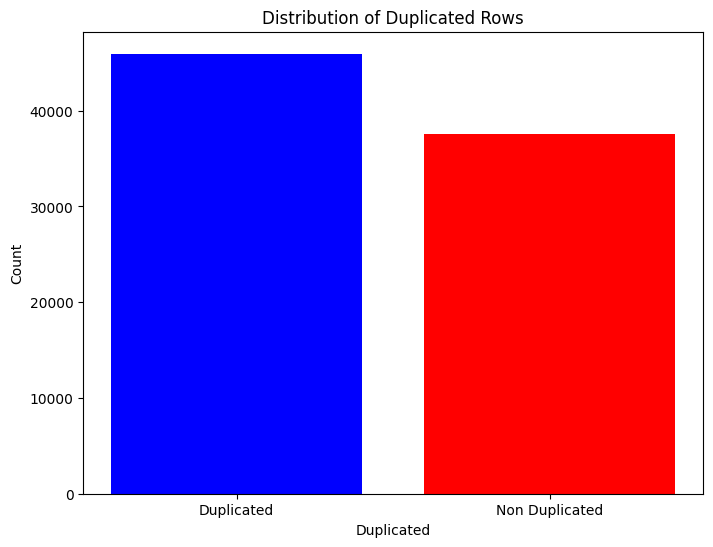

In [315]:
#Find and count duplicated rows
duplicated_counts = data_transaction.duplicated().value_counts()

# Plot the distribution of duplicated rows
plt.figure(figsize=(8, 6))
plt.bar(['Duplicated', 'Non Duplicated'], duplicated_counts, color=['blue', 'red'])
plt.title('Distribution of Duplicated Rows')
plt.xlabel('Duplicated')
plt.ylabel('Count')
plt.show()

We have 45955 duplicated data, however  In transactional data, duplicated rows may not necessarily indicate an issue that needs to be resolved by deleting the duplicates. Duplicated rows in transactional data can often be expected and legitimate, especially when transactions can occur multiple times for the same entity or under certain conditions.

In [316]:
#checking null values
data_train.isnull().sum()

ID              0
Store_nbr       0
Family          0
Onpromotion     0
Year            0
Month           0
Weekday Name    0
Sales($)        0
dtype: int64

<Axes: >

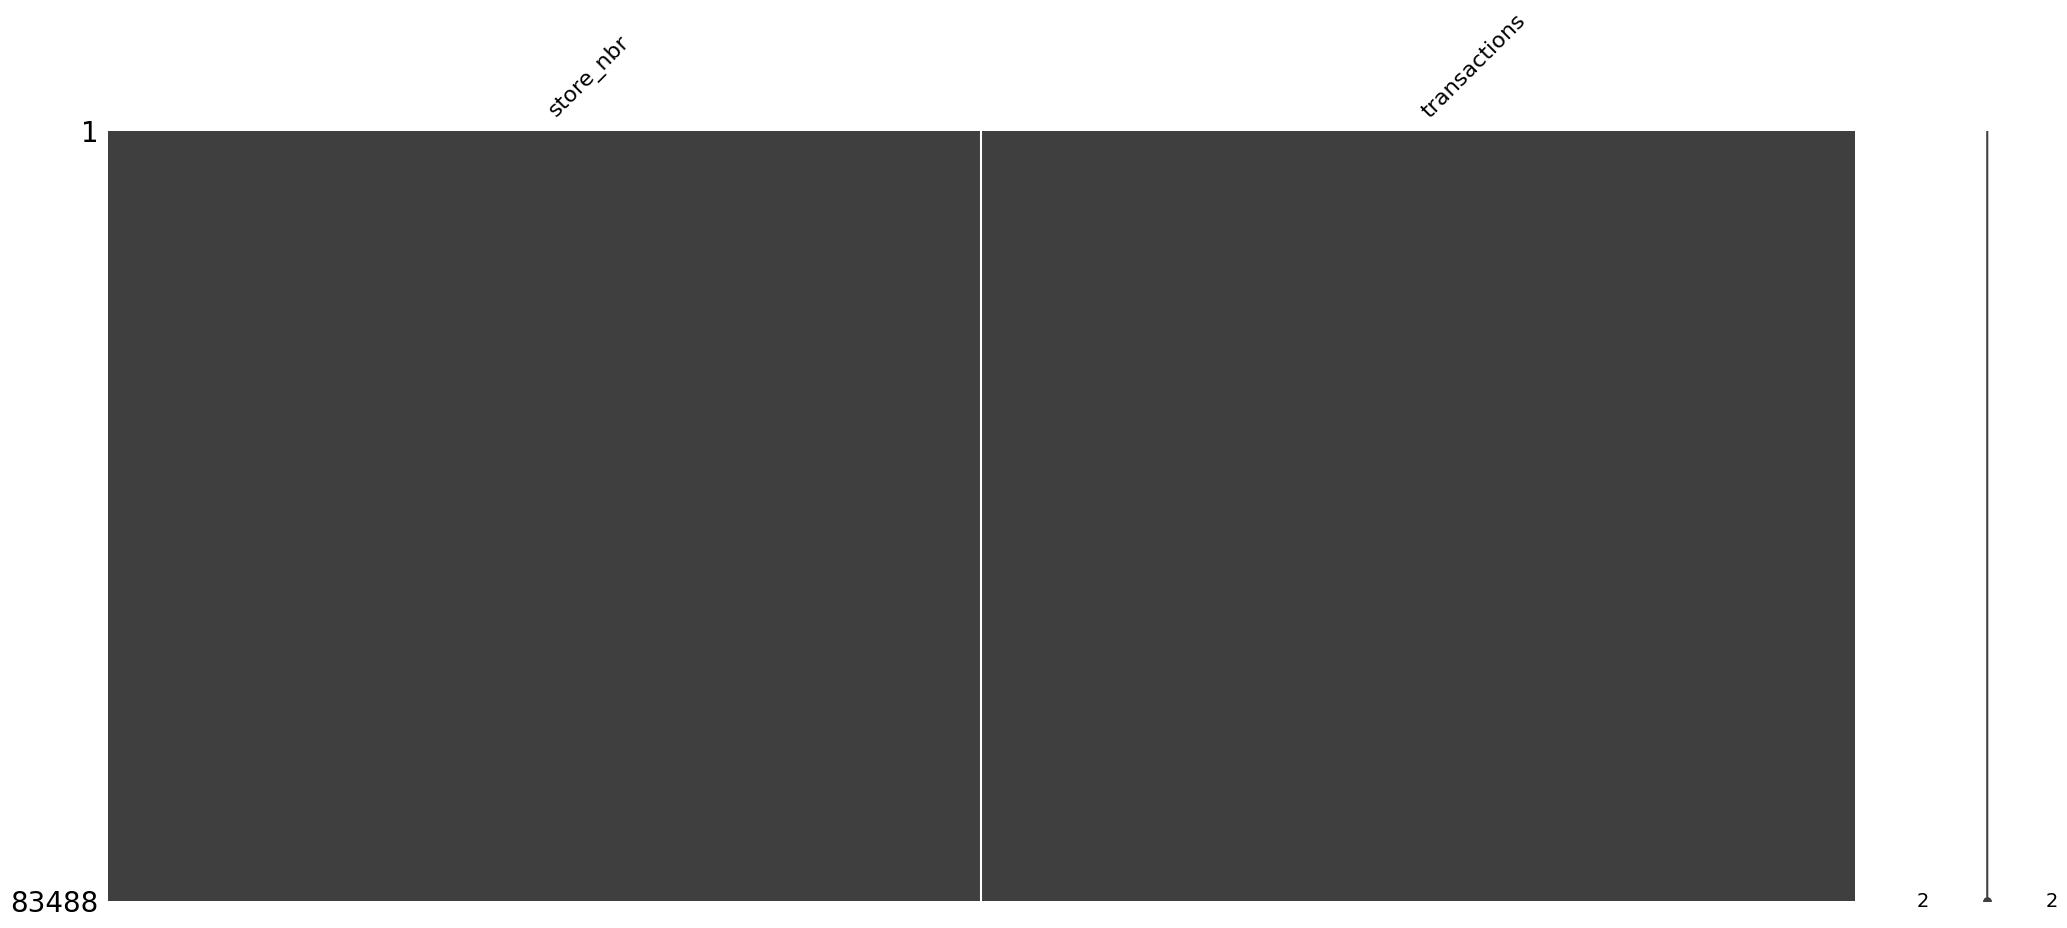

In [317]:
msno.matrix(data_transaction)

There are no null values. Lets check the statistical distribution

In [318]:
#checking statistical distribution
data_transaction.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


In [319]:
#checking for dtypes
data_transaction.dtypes

store_nbr       int64
transactions    int64
dtype: object

In [320]:
#lets convert all numeric columns to numeric using pandas and recheck missing values
data_transaction['store_nbr'] = pd.to_numeric(data_transaction['store_nbr'], errors='coerce')
data_transaction['transactions'] = pd.to_numeric(data_transaction['transactions'], errors='coerce')

In [321]:
#Rechecking for missing values
data_transaction.isnull().sum()

store_nbr       0
transactions    0
dtype: int64

There are no missing values. Lets create new features from the data column i.e Year,Month and Weekday Name

In [322]:
#By use pandas lets create a time series
data_transaction['Year'] = data_transaction.index.year
data_transaction['Month'] = data_transaction.index.month
data_transaction['WeekDay Name'] = data_transaction.index.day_name()

#Show the dataframe part of dataframe using .head()
data_transaction.head()

,store_nbr,transactions,Year,Month,WeekDay Name
date,,,,,
2013-01-01,25,770,2013,1,Tuesday
2013-01-02,1,2111,2013,1,Wednesday
2013-01-02,2,2358,2013,1,Wednesday
2013-01-02,3,3487,2013,1,Wednesday
2013-01-02,4,1922,2013,1,Wednesday


In [323]:
# Rename the columns
data_transaction = data_transaction.rename(columns={
    'store_nbr': 'Store_nbr',
    'transactions': 'Transaction',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name'
})

The final Cleaned Transaction Dataset

In [324]:
data_transaction.head()

,Store_nbr,Transaction,Year,Month,Weekday Name
date,,,,,
2013-01-01,25,770,2013,1,Tuesday
2013-01-02,1,2111,2013,1,Wednesday
2013-01-02,2,2358,2013,1,Wednesday
2013-01-02,3,3487,2013,1,Wednesday
2013-01-02,4,1922,2013,1,Wednesday


- Cleaning Store DataSet

In [325]:
#check the dataframe
data_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [326]:
#Checking duplicated data
data_stores.duplicated().sum()

0

There are no duplicated rows lets check the null values

In [327]:
#checking null values
data_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

<Axes: >

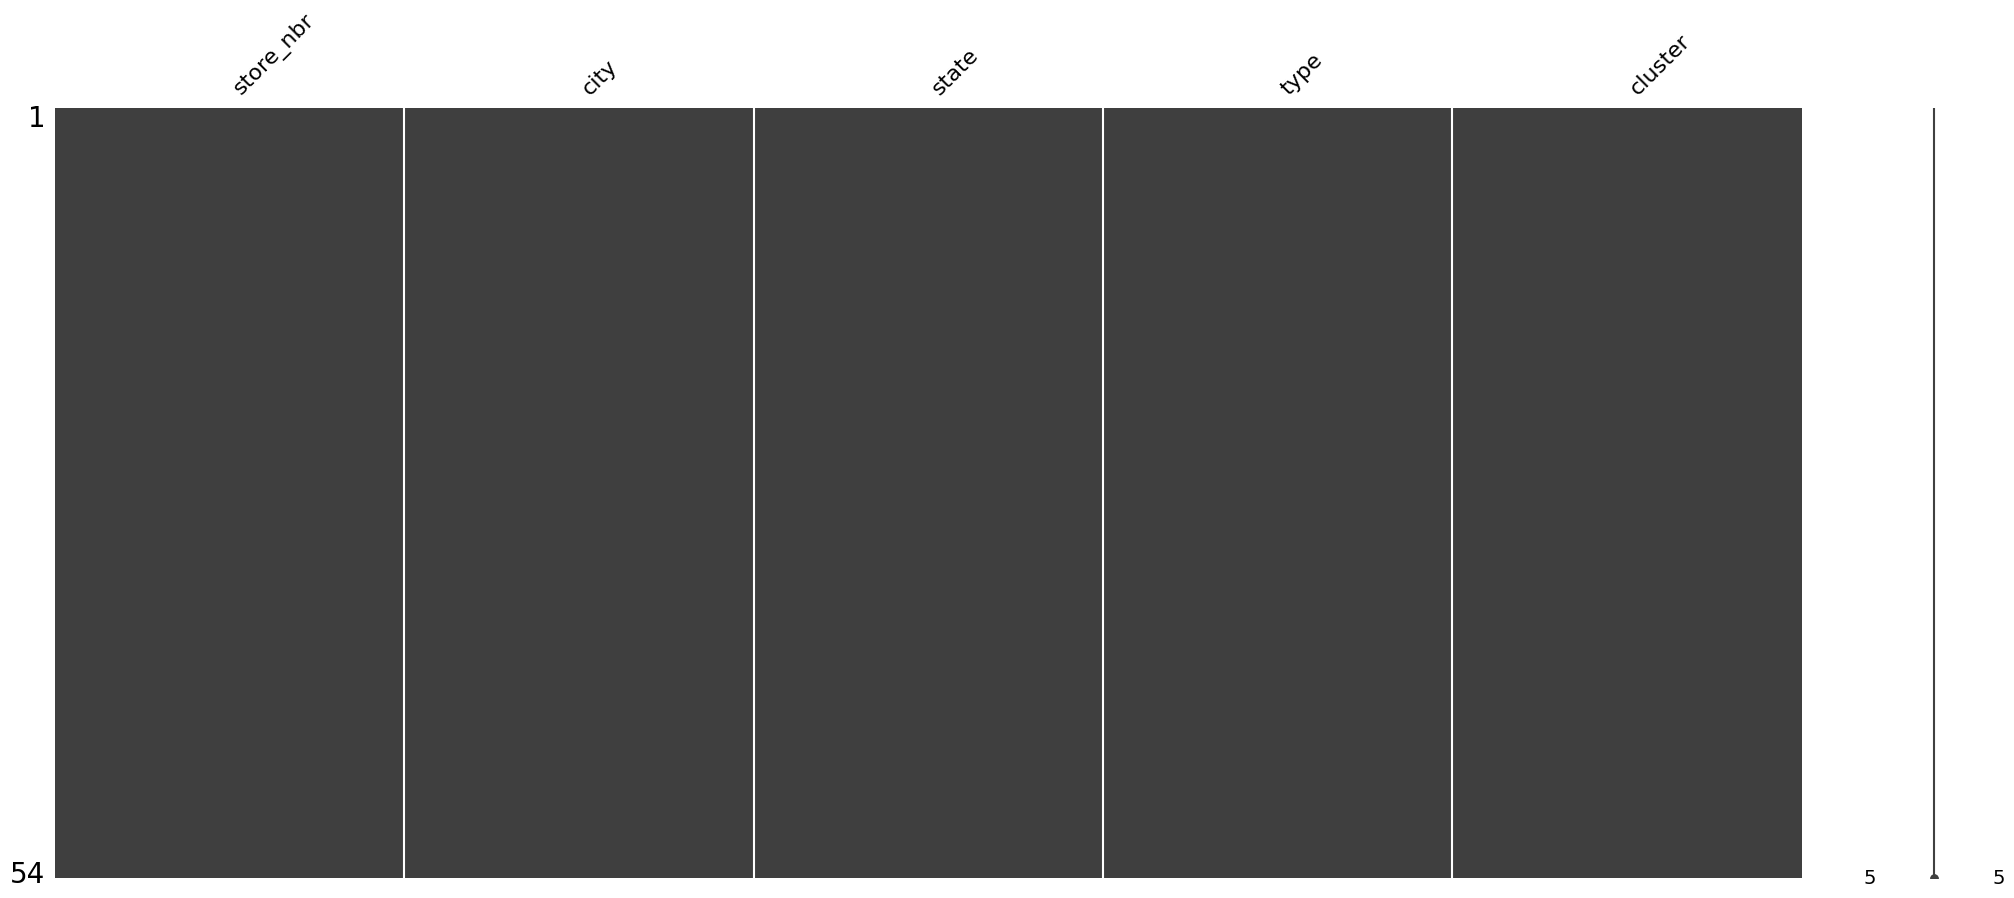

In [328]:
msno.matrix(data_stores)

There are no missing values, lets check statatical distribution

In [329]:
#checking statistical distribution
data_stores.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
store_nbr,54.0,NaN,NaN,NaN,27.5,15.732133,1.0,14.25,27.5,40.75,54.0
city,54,22,Quito,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,54,16,Pichincha,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,54,5,D,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster,54.0,NaN,NaN,NaN,8.481481,4.693395,1.0,4.0,8.5,13.0,17.0


From Stastical distribution: The state Pichincha and Quito city are most frequent store locations. We will see the distribution in the EDA analysis step.

In [330]:
#checking for dtypes
data_stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [331]:
#lets convert all numeric columns to numeric using pandas 
# then recheck missing values
data_stores['store_nbr'] = pd.to_numeric(data_stores['store_nbr'], errors='coerce')
data_stores['cluster'] = pd.to_numeric(data_stores['cluster'], errors='coerce')

In [332]:
#Rechecking for missing values
data_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

There are no missing values. Lets rename the columns to start with capital letter

In [333]:
# Rename the columns
data_stores = data_stores.rename(columns={
    'store_nbr': 'Store_nbr',
    'city': 'City',
    'state': 'State',
    'type': 'Type',
    'cluster': 'Cluster'
})

The final cleaned store data

In [334]:
data_stores.head()

,Store_nbr,City,State,Type,Cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


- Cleaning Oil data

In [335]:
#check the dataframe
data_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [336]:
#Checking duplicated data
# Find and display duplicated rows in the DataFrame
duplicated_rows = data_oil[data_oil.duplicated()]
print(duplicated_rows)

            dcoilwtico
date                  
2013-01-21         NaN
2013-02-15   95.949997
2013-02-18         NaN
2013-02-22   93.120003
2013-03-19   92.440002
...                ...
2017-08-23   48.450001
2017-08-24   47.240002
2017-08-25   47.650002
2017-08-28   46.400002
2017-08-29   46.459999

[219 rows x 1 columns]


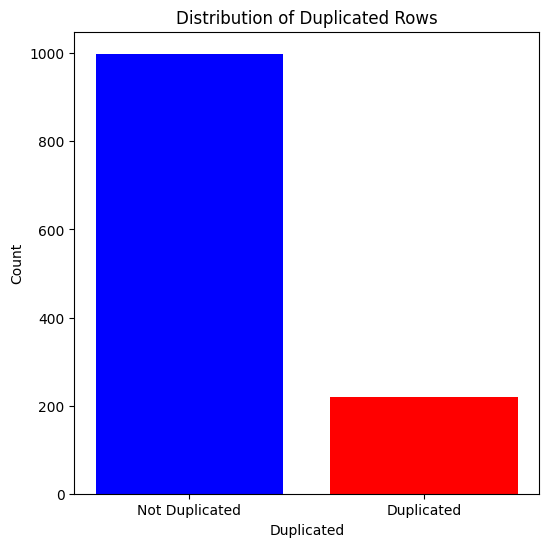

In [337]:
# Find and count duplicated rows
duplicated_count = data_oil.duplicated().value_counts()

# Create a count plot to visualize the distribution of duplicated rows
plt.figure(figsize=(6, 6))
plt.bar(['Not Duplicated', 'Duplicated'], duplicated_count, color=['blue', 'red'])
plt.title('Distribution of Duplicated Rows')
plt.xlabel('Duplicated')
plt.ylabel('Count')
plt.show()


We have 219 rows duplicated, it suggests that the same daily price rate occurred on multiple days. In this scenario, there is typically no need to remove duplicates, as these duplicated rows represent valid and meaningful data.

In [338]:
#checking null values
data_oil.isnull().sum()

dcoilwtico    43
dtype: int64

<Axes: >

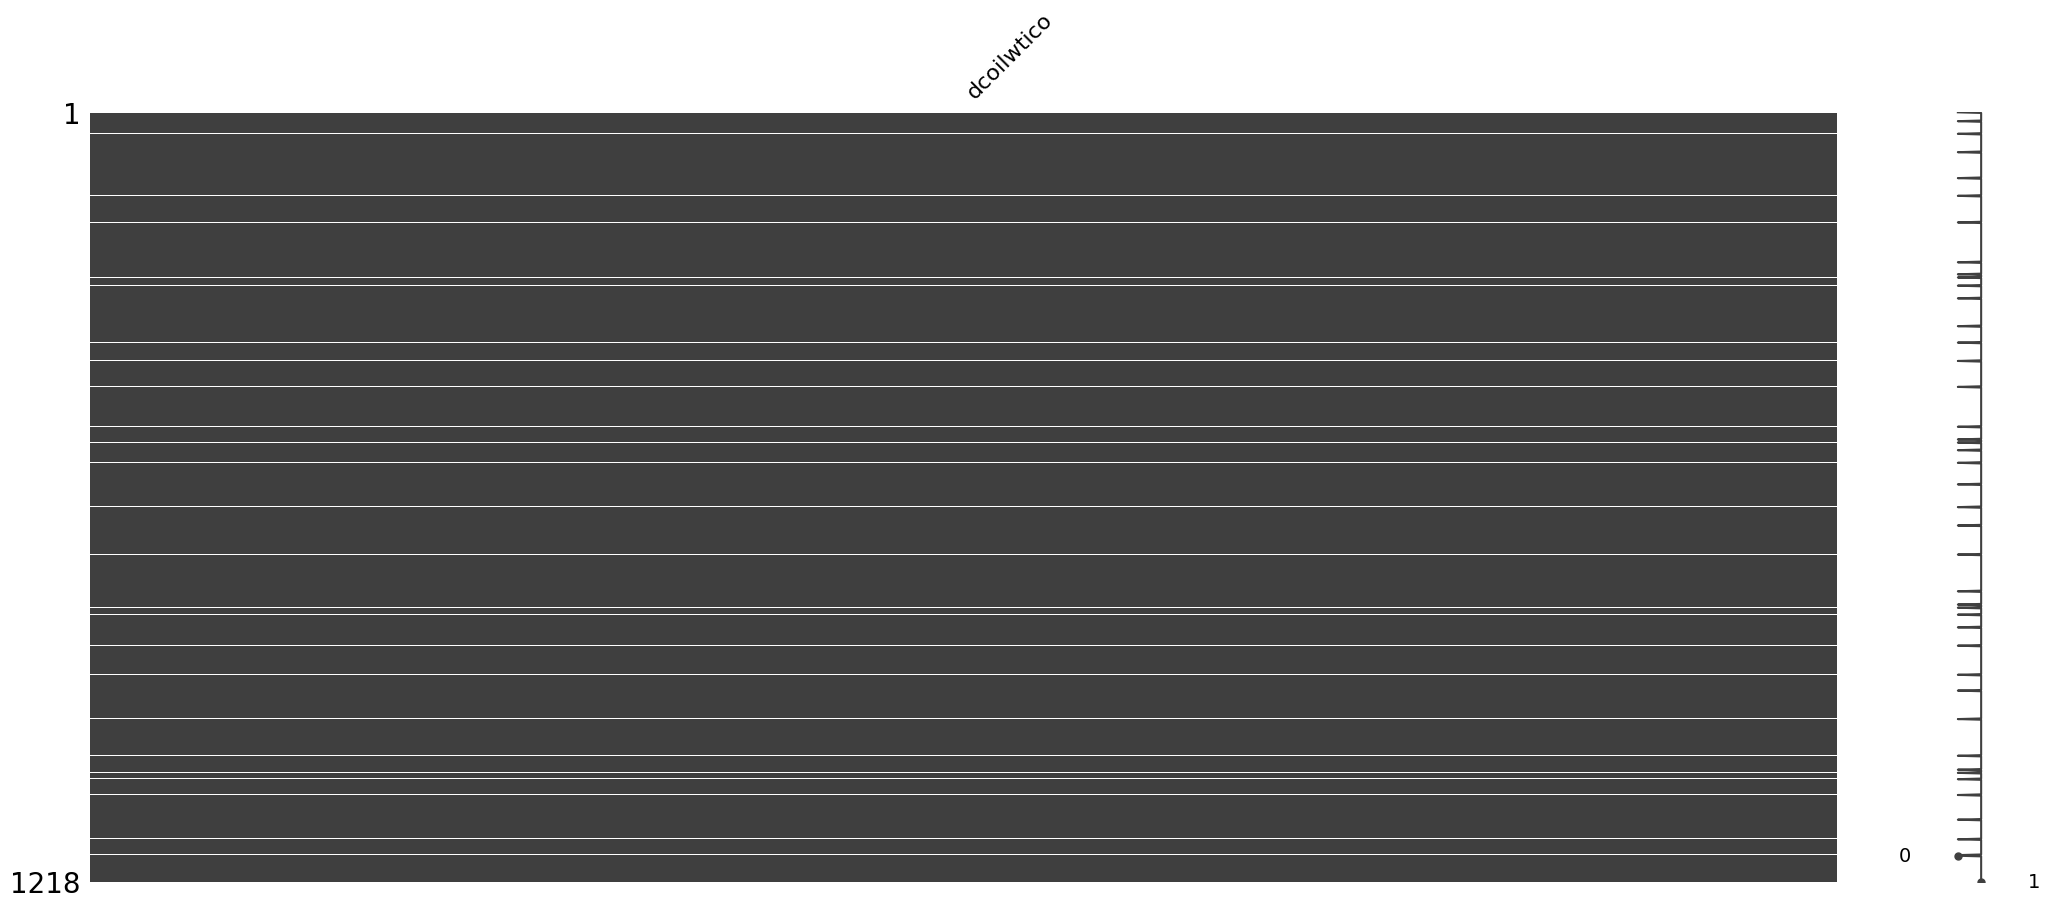

In [339]:
msno.matrix(data_oil)

We have 43 missing values in the oil dataset. Lets fill the values using interpolation

In [340]:
# Interpolate missing values using the default linear method
data_oil['dcoilwtico'].interpolate(method='linear', inplace=True)
# Check if there are any remaining missing values
missing_values = data_oil['dcoilwtico'].isnull().sum()

if missing_values == 0:
    print("All missing values have been filled.")
else:
    print(f"There are still {missing_values} missing values.")

There are still 1 missing values.


Lets fill the missing value with bfill method.

In [341]:
# imputing NaN values form the dataset
data_oil = data_oil.fillna(method='bfill')

In [342]:
#rechecking missing values
data_oil.isnull().sum()

dcoilwtico    0
dtype: int64

The missing values has been handled, lets now see the statistical distribution

In [343]:
#checking statistical distribution
data_oil.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1218.0,67.682742,25.632933,26.190001,46.4225,53.184999,95.684999,110.620003


In [344]:
#checking datatypes 
data_oil.dtypes

dcoilwtico    float64
dtype: object

In [345]:
#lets convert all numeric columns to numeric using pandas 
# then recheck missing values
data_oil['dcoilwtico'] = pd.to_numeric(data_oil['dcoilwtico'], errors='coerce')

In [346]:
#rechecking missing values
data_oil.isnull().sum()

dcoilwtico    0
dtype: int64

There are no missing values even after changing the numerical columns to numeric. Lets create new features from the data column i.e Year,Month and Weekday Name

In [347]:
# the index is a datetime index
data_oil.index = pd.to_datetime(data_oil.index)

# Create columns for year, month, and weekday name
data_oil['Year'] = data_oil.index.year
data_oil['Month'] = data_oil.index.month
data_oil['WeekDay Name'] = data_oil.index.day_name()

# Show the DataFrame using .head()
data_oil.head()

,dcoilwtico,Year,Month,WeekDay Name
date,,,,
2013-01-01,93.139999,2013,1,Tuesday
2013-01-02,93.139999,2013,1,Wednesday
2013-01-03,92.970001,2013,1,Thursday
2013-01-04,93.120003,2013,1,Friday
2013-01-07,93.199997,2013,1,Monday


In [348]:
# Rename the columns
data_oil = data_oil.rename(columns={
    'dcoilwtico': 'Daily Oil Price',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name',
})

The final cleaned oil data


In [349]:
data_oil.head()

,Daily Oil Price,Year,Month,Weekday Name
date,,,,
2013-01-01,93.139999,2013,1,Tuesday
2013-01-02,93.139999,2013,1,Wednesday
2013-01-03,92.970001,2013,1,Thursday
2013-01-04,93.120003,2013,1,Friday
2013-01-07,93.199997,2013,1,Monday


- Cleaning Events/Holiday Data

In [350]:
#check the dataframe
data_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [351]:
#Checking duplicated data
# Find and display duplicated rows in the DataFrame
dupli_rows = data_events[data_events.duplicated()]
print(dupli_rows)

                  type    locale locale_name                    description   
date                                                                          
2013-02-12     Holiday  National     Ecuador                       Carnaval  \
2013-03-02     Holiday     Local       Manta             Fundacion de Manta   
2013-04-01     Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2013-04-12     Holiday     Local      Cuenca            Fundacion de Cuenca   
2013-04-14     Holiday     Local    Libertad      Cantonizacion de Libertad   
...                ...       ...         ...                            ...   
2017-12-22  Additional  National     Ecuador                      Navidad-3   
2017-12-23  Additional  National     Ecuador                      Navidad-2   
2017-12-24  Additional  National     Ecuador                      Navidad-1   
2017-12-25     Holiday  National     Ecuador                        Navidad   
2017-12-26  Additional  National     Ecuador        

In [352]:
# Find and count duplicated rows
dupli_rows.value_counts()

type        locale    locale_name                     description                                 transferred
Holiday     National  Ecuador                         Carnaval                                    False          9
            Local     Machala                         Fundacion de Machala                        False          5
                      Guaranda                        Cantonizacion de Guaranda                   False          5
                                                      Independencia de Guaranda                   False          5
            National  Ecuador                         Navidad                                     False          5
            Local     Latacunga                       Cantonizacion de Latacunga                  False          5
                                                      Independencia de Latacunga                  False          5
                      Libertad                        Cantonizacion de Libertad      

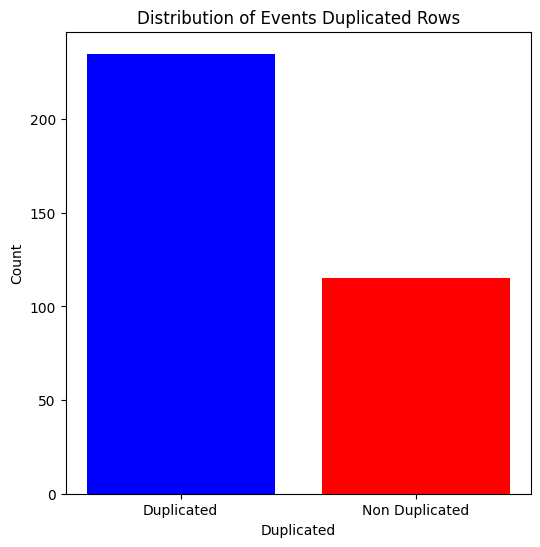

In [353]:
# Find and count duplicated rows
dupli_count = data_events.duplicated().value_counts()

# Create a count plot to visualize the distribution of duplicated rows
plt.figure(figsize=(6, 6))
plt.bar(['Duplicated', 'Non Duplicated'], dupli_count, color=['blue', 'red'])
plt.title('Distribution of Events Duplicated Rows')
plt.xlabel('Duplicated')
plt.ylabel('Count')
plt.show()

We have 235 duplicated holidays. This is because some holidays had been transferred and aslo there is existence of additional and Bridge holidays. There no need to delete the duplicates as they form part of our analysis.

In [354]:
#checking null values
data_events.isnull().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

<Axes: >

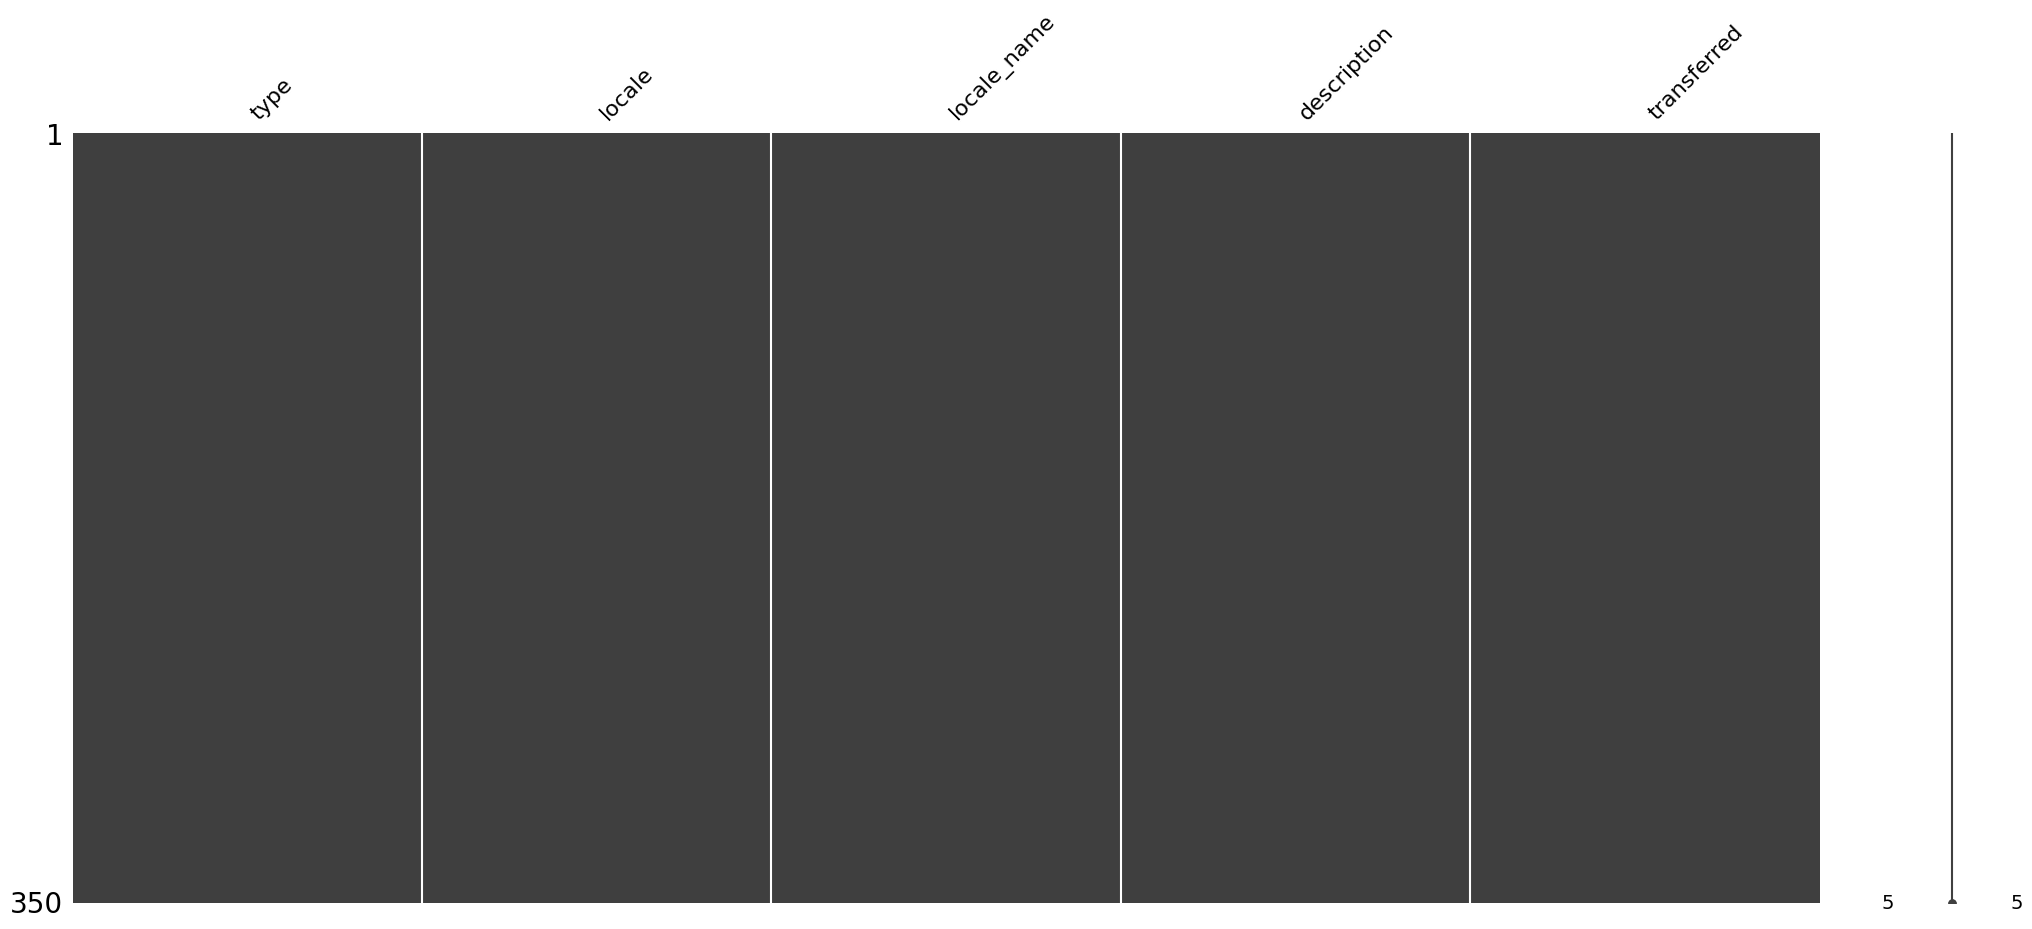

In [355]:
#Lets plot the variables on a matrix
msno.matrix(data_events)

There are no missing values in the Holiday/Event Dataset. Lets create new features on date columns - Year,Month and Day of the week/Date

In [356]:
# the index is a datetime index
data_events.index = pd.to_datetime(data_events.index)

# Create columns for year, month, and weekday name
data_events['Year'] = data_events.index.year
data_events['Month'] = data_events.index.month
data_events['WeekDay Name'] = data_events.index.day_name()

# Show the DataFrame using .head()
data_events.head()

,type,locale,locale_name,description,transferred,Year,Month,WeekDay Name
date,,,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,Friday
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,Sunday
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,Thursday
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,Saturday
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,Saturday


In [357]:
# Rename the columns to start with capital letters
data_events = data_events.rename(columns={
    'type': 'Type',
    'locale': 'Locale',
    'locale_name': 'Locale_Name',
    'description': 'Description',
    'transferred': 'Transferred',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name',
})

The final cleaned Holiday/Events dataset

In [358]:
# Final holiday dataset
data_events.head(5)

,Type,Locale,Locale_Name,Description,Transferred,Year,Month,Weekday Name
date,,,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,Friday
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,Sunday
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,Thursday
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,Saturday
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,Saturday


#### EDA ANALYSIS - understanding relationships and correlations between features of different datasets

Train dataset relationships

In [359]:
# datasets
data_train.tail()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2017-08-15,3000883,9,POULTRY,0,2017,8,Tuesday,438.133
2017-08-15,3000884,9,PREPARED FOODS,1,2017,8,Tuesday,154.553
2017-08-15,3000885,9,PRODUCE,148,2017,8,Tuesday,2419.729
2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,8,2017,8,Tuesday,121.000
2017-08-15,3000887,9,SEAFOOD,0,2017,8,Tuesday,16.000


In [360]:
#get a row - time series
data_train.loc['2013-01-13']

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-13,21384,1,AUTOMOTIVE,0,2013,1,Sunday,2.000
2013-01-13,21385,1,BABY CARE,0,2013,1,Sunday,0.000
2013-01-13,21386,1,BEAUTY,0,2013,1,Sunday,0.000
2013-01-13,21387,1,BEVERAGES,0,2013,1,Sunday,572.000
2013-01-13,21388,1,BOOKS,0,2013,1,Sunday,0.000
...,...,...,...,...,...,...,...,...
2013-01-13,23161,9,POULTRY,0,2013,1,Sunday,540.596
2013-01-13,23162,9,PREPARED FOODS,0,2013,1,Sunday,88.000
2013-01-13,23163,9,PRODUCE,0,2013,1,Sunday,0.000


In [361]:
#grab a specific month
data_train.loc['2013-01']

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0,2013,1,Tuesday,0.000
2013-01-01,1,1,BABY CARE,0,2013,1,Tuesday,0.000
2013-01-01,2,1,BEAUTY,0,2013,1,Tuesday,0.000
2013-01-01,3,1,BEVERAGES,0,2013,1,Tuesday,0.000
2013-01-01,4,1,BOOKS,0,2013,1,Tuesday,0.000
...,...,...,...,...,...,...,...,...
2013-01-31,55237,9,POULTRY,0,2013,1,Thursday,335.215
2013-01-31,55238,9,PREPARED FOODS,0,2013,1,Thursday,42.000
2013-01-31,55239,9,PRODUCE,0,2013,1,Thursday,0.000


<Axes: xlabel='date'>

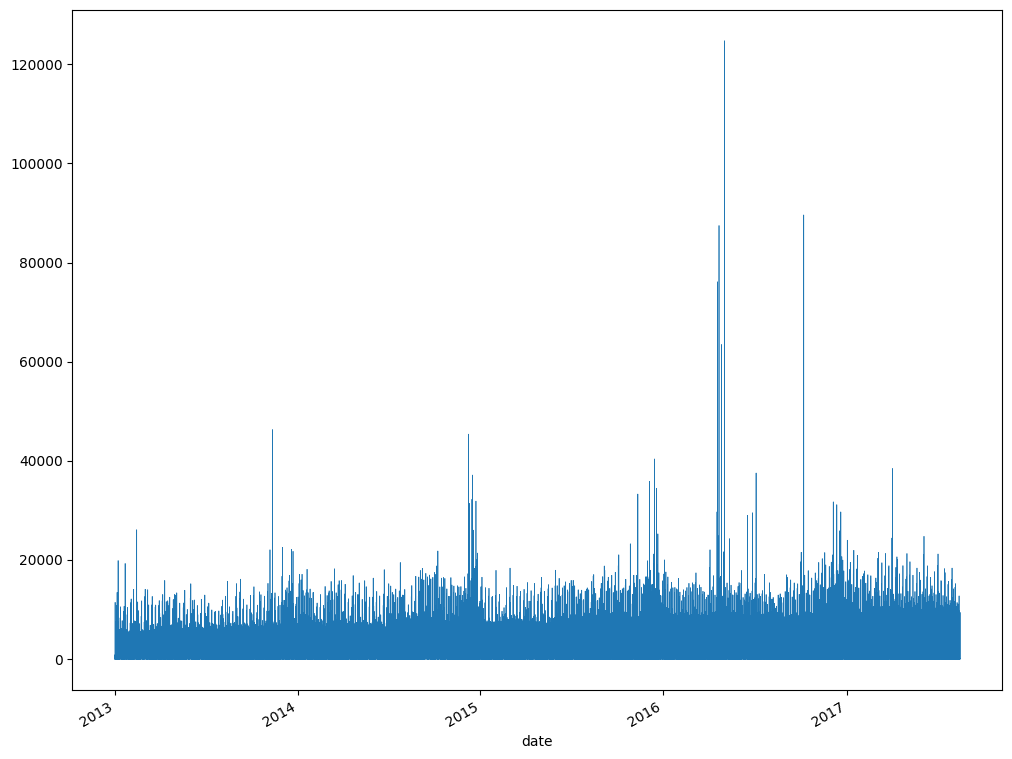

In [362]:
#Vizualizing to examine sales in time series
plt.figure(figsize = (12,10))
data_train['Sales($)'].plot(linewidth = 0.5)

 There is increase of sales over time, it indicating a positive relationship between sales and time, specifically a positive linear relationship. In a positive linear relationship, as the independent variable (in this case, time represented by years) increases, the dependent variable (sales) also increases in a roughly linear fashion. This suggests that there is a positive correlation between time and sales, meaning that, on average, sales tend to increase as time goes by. Lets plot a time series chart to have a look at the relationship of sales and other categorical columns

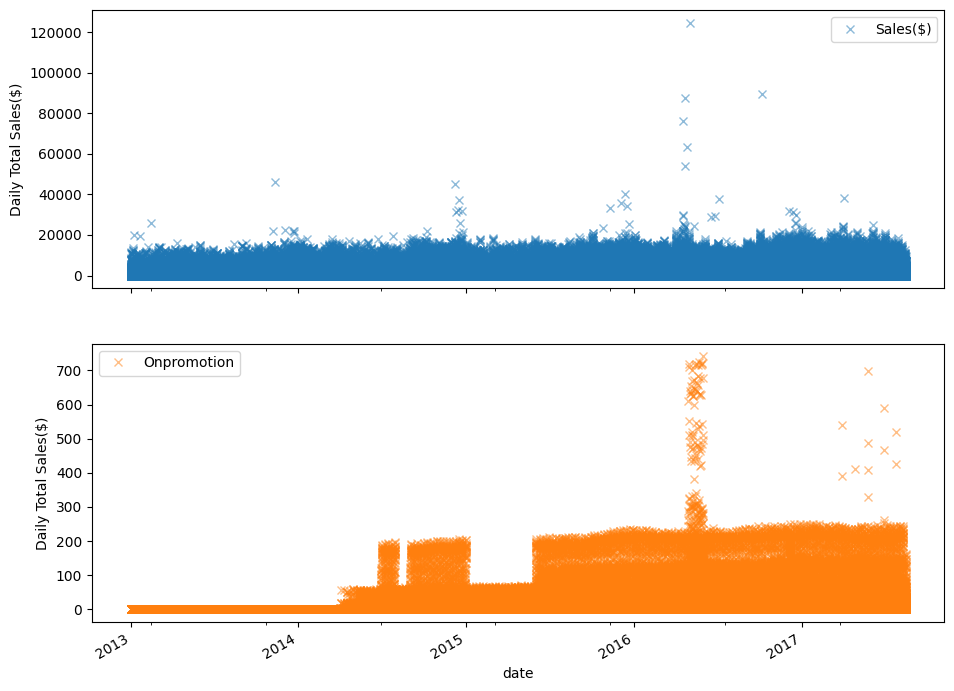

In [363]:
#other columns - store and product family relations with sales over time
coln_plot = ['Sales($)','Onpromotion','Family']
axes = data_train[coln_plot].plot(marker = 'x',alpha = 0.5,linestyle = 'None',figsize = (11,9),subplots = True)
for ax in axes:
   ax.set_ylabel('Daily Total Sales($)')

Things to note from the relationships.
- There is increase in sales when the items are onpromotion. 
- Also there is different number coding of items on promotion. Not the usual binary 0 - for No and 1 - for Yes. There is a possibility that the onpromotion entries indicates number of items sold on promotion. 

In [364]:
#onpromotion entries
data_train['Onpromotion'].value_counts()

Onpromotion
0      2389559
1       174551
2        79386
3        45862
4        31659
        ...   
313          1
452          1
642          1
305          1
425          1
Name: count, Length: 362, dtype: int64

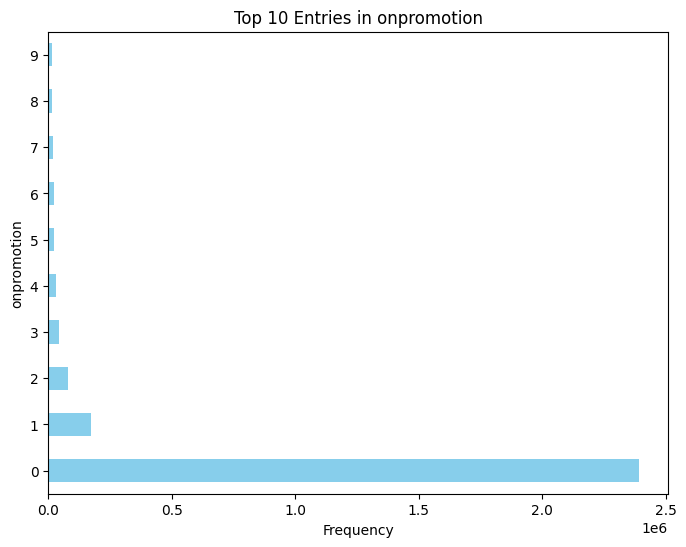

In [365]:

# Calculate the frequency (count) of each unique value in 'onpromotion'
onpromotion_counts = data_train['Onpromotion'].value_counts()

# Select the top 10 entries based on value counts
top_10_onpromotion = onpromotion_counts.head(10)

# Create a horizontal bar plot to visualize the top 10 entries
plt.figure(figsize=(8, 6))
top_10_onpromotion.plot(kind='barh', color='skyblue')
plt.title('Top 10 Entries in onpromotion')
plt.ylabel('onpromotion')
plt.xlabel('Frequency')
plt.show()

In [366]:
data_train.dtypes

ID                int64
Store_nbr         int64
Family           object
Onpromotion       int64
Year              int32
Month             int32
Weekday Name     object
Sales($)        float64
dtype: object

Plotting a heat map to check correlation of numerical variables in the train data



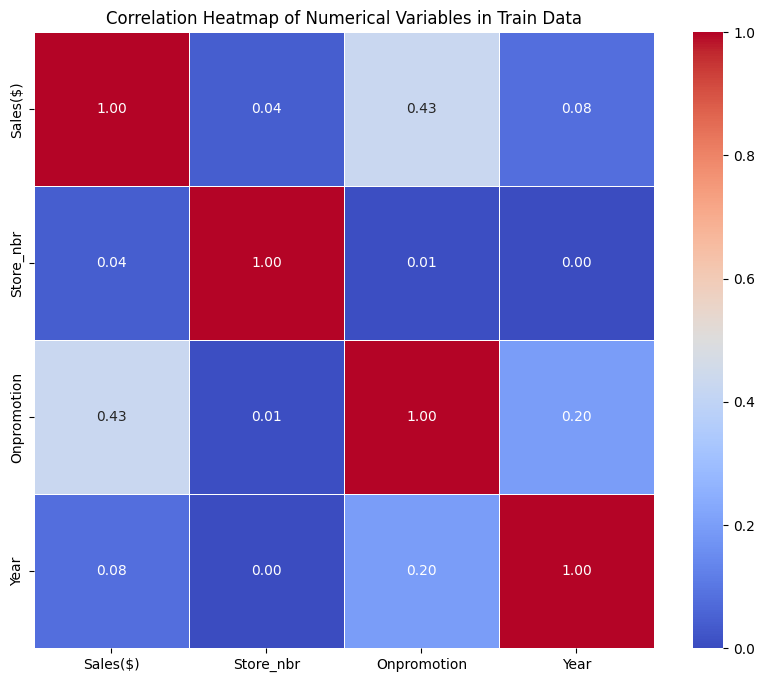

In [367]:
# numerical features
numerical = ['Sales($)','Store_nbr','Onpromotion','Year']
# Calculate the correlation matrix
correlation_matrix = data_train[numerical].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add labels and title
plt.title("Correlation Heatmap of Numerical Variables in Train Data")
plt.show()

There is a strong Relationship between Store_nbr, onpromotion,Sales and period in Years.

### Extracting files for PowerBI Deployment
Here we are going to extract all  cleaned files for powerBI deployment

In [368]:
# convert file to csv_file

#data_train.to_csv(r'C:\file_path.data_train.csv', index=True)
#data_oil.to_csv(r'C:file_path.data_oil.csv', index=True)
#data_transaction.to_csv(r'C:filepath.data_transaction.csv', index=True)
#data_events.to_csv(r'C:file_path.data_events.csv', index=True)
#data_stores.to_csv(r'C:file_path.data_stores.csv', index=False)
print("csv files generated successfully.")


csv files generated successfully.


### 2.2.4 Answering The Smart Business Questions

- The required Questions

**1. Is the train dataset complete (has all the required dates)?**

In [369]:
# Define the expected date range (start and end dates)
expected_start_date = '2013-01-01'  # Replace with your actual start date
expected_end_date = '2017-08-15'    # Replace with your actual end date

# Convert the expected start and end dates to pandas datetime objects
expected_start_date = pd.to_datetime(expected_start_date)
expected_end_date = pd.to_datetime(expected_end_date)

# Create an expected date range
expected_date_range = pd.date_range(start=expected_start_date, end=expected_end_date)

# Check for missing dates in the index
missing_dates = expected_date_range.difference(data_train.index)

if missing_dates.empty:
    print("The train dataset is complete. It contains all the required dates.")
else:
    print("The train dataset has missing dates in the index:")
    print(missing_dates)

The train dataset has missing dates in the index:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


The dates missing are chrismas days of the 4 years i.e 2013, 2014, 2015 and 2016. The succeeding Analysis assumes that no data was taken on this day as the shops may be closed down each year

**2. Which dates have the lowest and highest sales for each year?**

   Year Lowest Sales Date  Lowest Sales Value Highest Sales Date   
0  2013        2013-01-01                 0.0         2013-11-12  \
1  2014        2014-01-01                 0.0         2014-12-08   
2  2015        2015-01-01                 0.0         2015-12-14   
3  2016        2016-01-01                 0.0         2016-05-02   
4  2017        2017-01-01                 0.0         2017-04-02   

   Highest Sales Value  
0            46271.000  
1            45361.000  
2            40351.460  
3           124717.000  
4            38422.625  


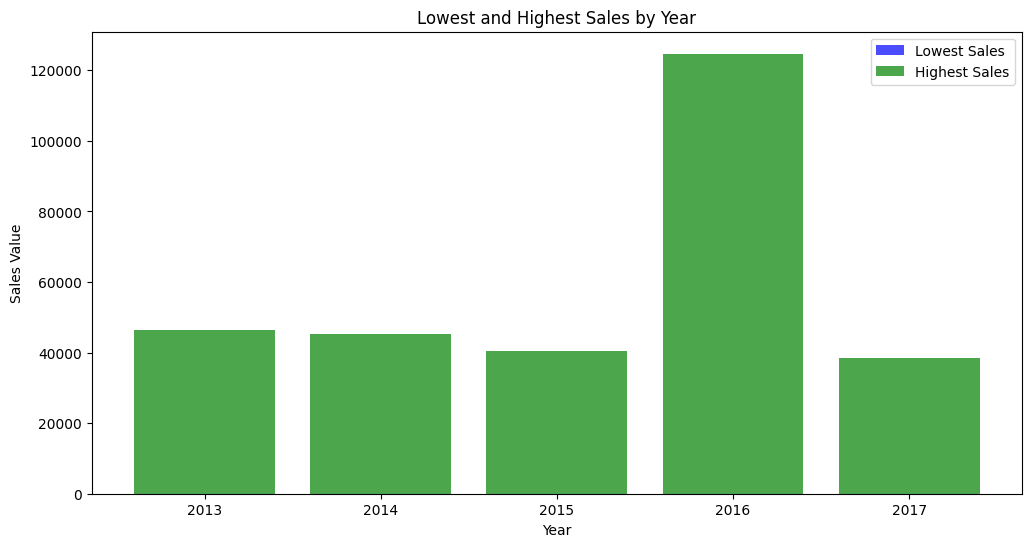

In [370]:
# Group the data by year
grouped_by_year = data_train.groupby(data_train.index.year)

# Initialize lists to store the results
years = []
lowest_sales_dates = []
lowest_sales_values = []
highest_sales_dates = []
highest_sales_values = []

# Iterate through each year and filter lowest and highest sales dates
for year, group in grouped_by_year:
    years.append(year)
    
    lowest_sales_date = group['Sales($)'].idxmin()
    lowest_sales_dates.append(lowest_sales_date)
    lowest_sales_value = group['Sales($)'].min()
    lowest_sales_values.append(lowest_sales_value)
    
    highest_sales_date = group['Sales($)'].idxmax()
    highest_sales_dates.append(highest_sales_date)
    highest_sales_value = group['Sales($)'].max()
    highest_sales_values.append(highest_sales_value)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Year': years,
    'Lowest Sales Date': lowest_sales_dates,
    'Lowest Sales Value': lowest_sales_values,
    'Highest Sales Date': highest_sales_dates,
    'Highest Sales Value': highest_sales_values
})

# Print the results DataFrame
print(results_df)

# Visualize the results with a bar chart
plt.figure(figsize=(12, 6))
plt.bar(years, lowest_sales_values, label='Lowest Sales', color='b', alpha=0.7)
plt.bar(years, highest_sales_values, label='Highest Sales', color='g', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Sales Value')
plt.title('Lowest and Highest Sales by Year')
plt.legend()
plt.xticks(years)
plt.show()

The lowest sales are seen in the start of every year with no sales at all, being a new year mostly the store remains closed. 
The highest sales were seen in 2016 May.

**3. Did the earthquake impact sales?**

EarthQuake experienced on April 16, 2016


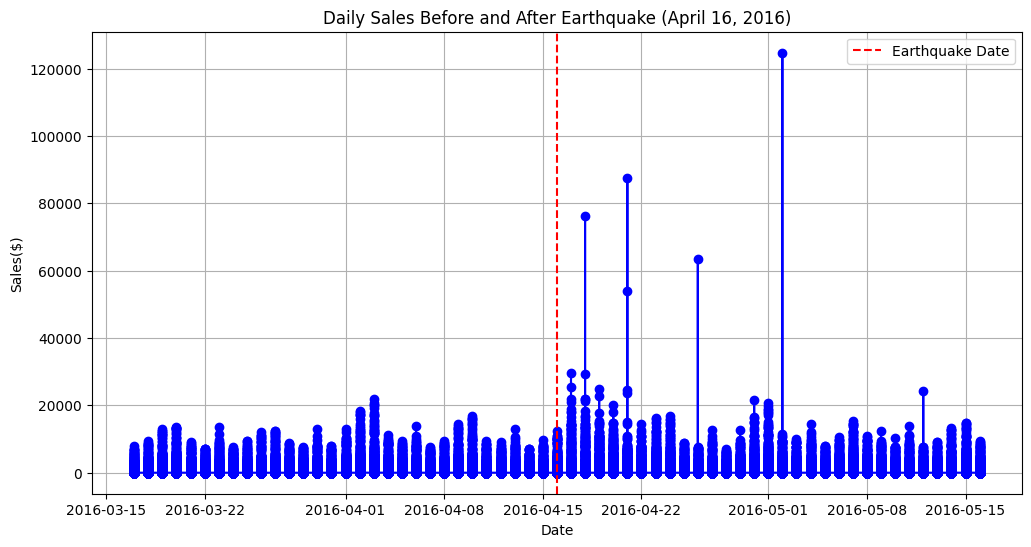

In [371]:
# Define the earthquake date and the window around it
earthquake_date = '2016-04-16'
window_before = 30  # Number of days before the earthquake
window_after = 30   # Number of days after the earthquake

# Calculate the start and end dates for the window
start_date = pd.to_datetime(earthquake_date) - pd.DateOffset(days=window_before)
end_date = pd.to_datetime(earthquake_date) + pd.DateOffset(days=window_after)

# Step 1: Filter data for the specified date range around the earthquake
filtered_data = data_train[(data_train.index >= start_date) & (data_train.index <= end_date)]

# Step 2: Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['Sales($)'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales($)')
plt.title('Daily Sales Before and After Earthquake (April 16, 2016)')
plt.grid(True)
plt.axvline(pd.to_datetime(earthquake_date), color='red', linestyle='--', label='Earthquake Date')
plt.legend()

# Show the plot
plt.show()


From the graph is that there was a positve impact on sales during the earthquake. The positive impact on sales during an earthquake at a grocery store is a result of increased demand, supply chain dynamics, preparedness behavior, community support, and a commitment to business continuity, all of which collectively underscore the store's essential role in times of crisis.

**4. Are certain groups of stores selling more products? (Cluster, city, state, type)**

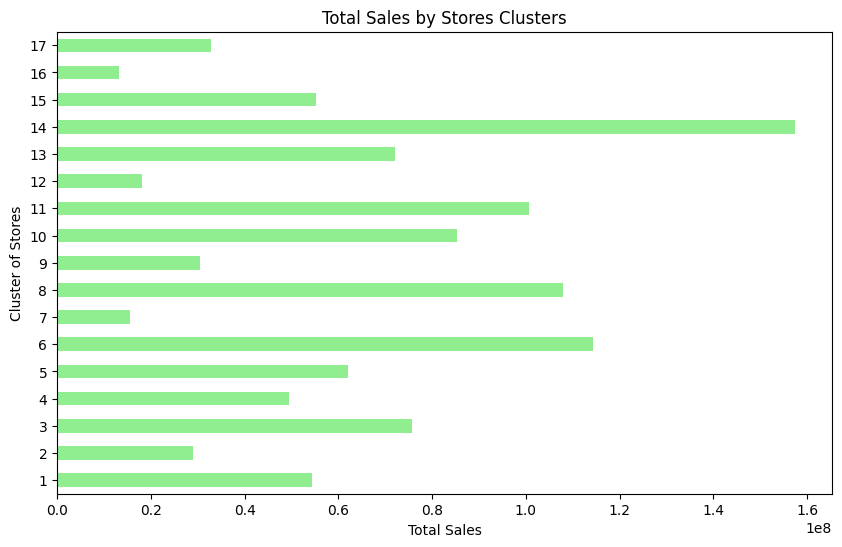

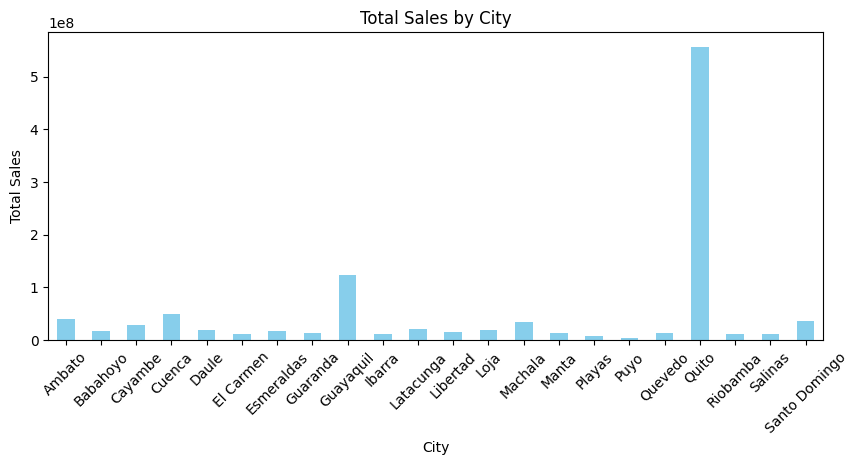

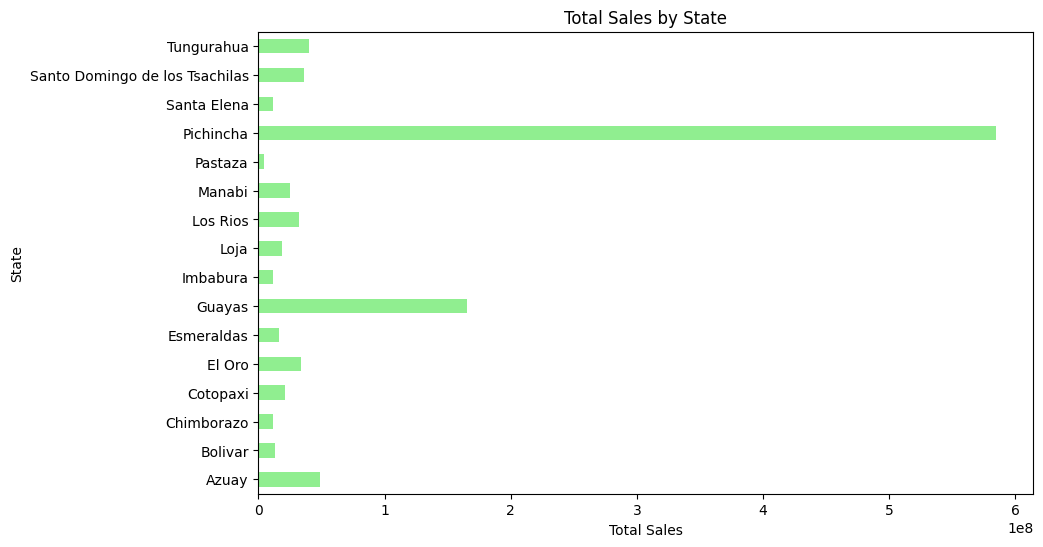

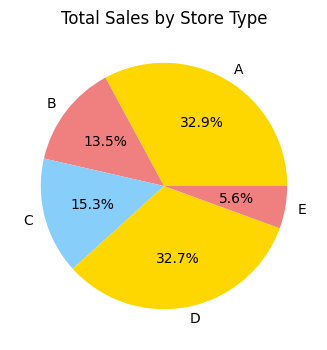

In [372]:
# Group data_train by 'Store_nbr' to calculate total sales for each store
store_sales = data_train.groupby('Store_nbr')['Sales($)'].sum().reset_index()

# Merge store_sales with data_stores on 'Store_nbr' to include store attributes
merged_data = store_sales.merge(data_stores, on='Store_nbr')

# Visualize total sales by Store_nbr as a horizontal bar chart
plt.figure(figsize=(10, 6))
merged_data.groupby('Cluster')['Sales($)'].sum().plot(kind='barh', color='lightgreen')
plt.title('Total Sales by Stores Clusters')
plt.ylabel('Cluster of Stores')
plt.xlabel('Total Sales')
plt.show()

# Visualize the total sales by City
plt.figure(figsize=(10, 4))
merged_data.groupby('City')['Sales($)'].sum().plot(kind='bar', color='skyblue')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

# Visualize the total sales by State as a horizontal bar chart
plt.figure(figsize=(10, 6))
merged_data.groupby('State')['Sales($)'].sum().plot(kind='barh', color='lightgreen')
plt.title('Total Sales by State')
plt.ylabel('State')
plt.xlabel('Total Sales')
plt.show()

# Visualize the total sales by Store Type
plt.figure(figsize=(8, 4))
merged_data.groupby('Type')['Sales($)'].sum().plot(kind='pie', autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue'])
plt.title('Total Sales by Store Type')
plt.ylabel('')
plt.show()

From the visualization here are some of the stores sales trends:

- **Stores Cluster 14:** Among various store clusters, Cluster 14 stands out as the top-performing group, consistently achieving the highest sales.

- **Quito City, State of Pichincha**: Quito City, located in the State of Pichincha, emerges as the geographical region with the highest sales, indicating a strong market presence and customer demand in this area.

- **Store Types A and D:** Stores categorized as Type A and Type D exhibit superior sales performance, emphasizing the significance of store types in influencing sales.

These findings provide valuable insights into the factors contributing to high sales and can serve as a basis for further analysis and decision-making to optimize sales strategies and resource allocation.

**5. Are sales affected by promotions, oil prices and holidays?**

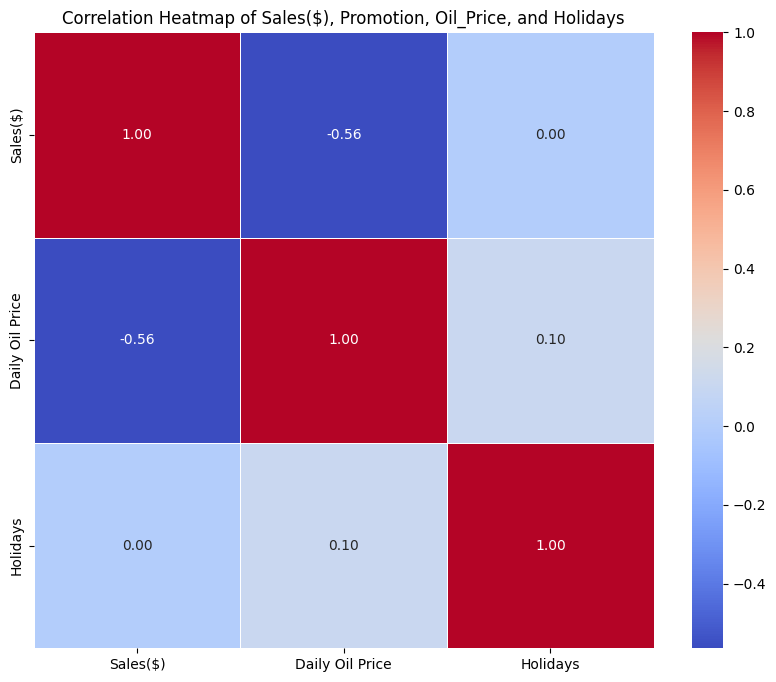

In [373]:
#convert the onpromtion variable to int
data_train['Onpromotion'] = data_train['Onpromotion'].astype(int)

# Step 1: Group by date and Sales($), picking only rows with Promotion > 0
filtered_sales_data = data_train[data_train['Onpromotion'] > 0]
sales_by_date = filtered_sales_data.groupby(filtered_sales_data.index)['Sales($)'].sum()

# Step 2: Group by date and Oil_Price
oil_prices_by_date = data_oil.groupby(data_oil.index)['Daily Oil Price'].mean()

# Step 3: Filter holidays (Transferred = False) and group by date
filtered_holidays = data_events[data_events['Transferred'] == False]
holidays_by_date = filtered_holidays.groupby(filtered_holidays.index).size().rename('Holidays')

# Step 4: Merge the results on the date index
merged_data = pd.concat([sales_by_date, oil_prices_by_date, holidays_by_date], axis=1, join='inner')

# Plot the correlations between Sales($), Promotion, Oil_Price, and Holidays
correlation_matrix = merged_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Sales($), Promotion, Oil_Price, and Holidays")
plt.show()

From the heatmap: 
- Promotions has positive correlations on sales, promotion increases sales
- The daily oil price has an a negative impacts on sales. Higher daily oil prices results to low sales.
- Holidays have weaker correlations on sales.  

**6. What analysis can we get from the date and its extractable features?**

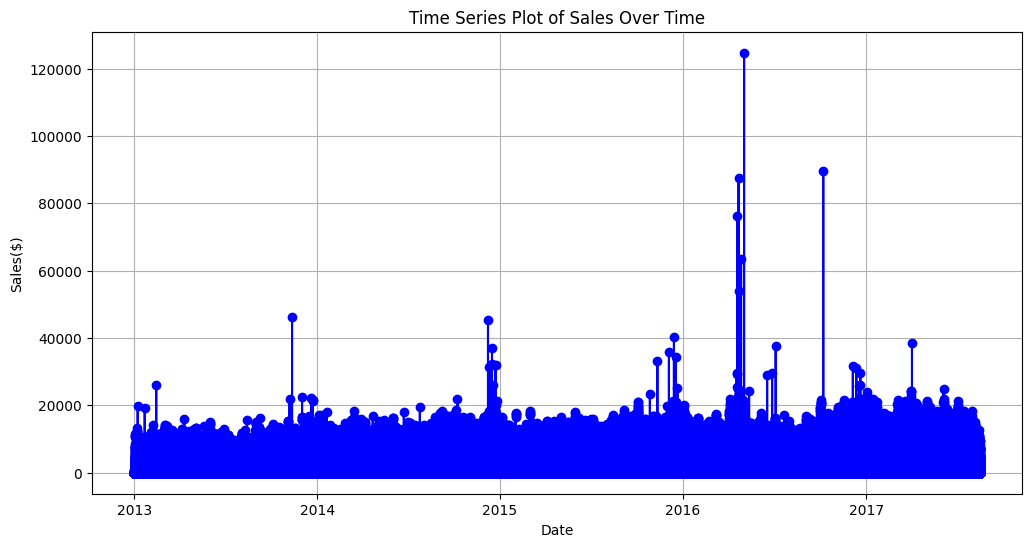

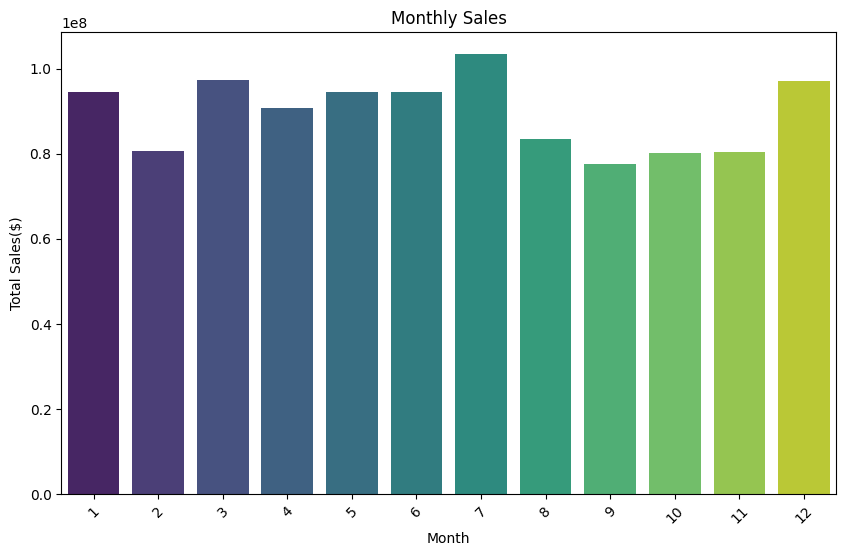

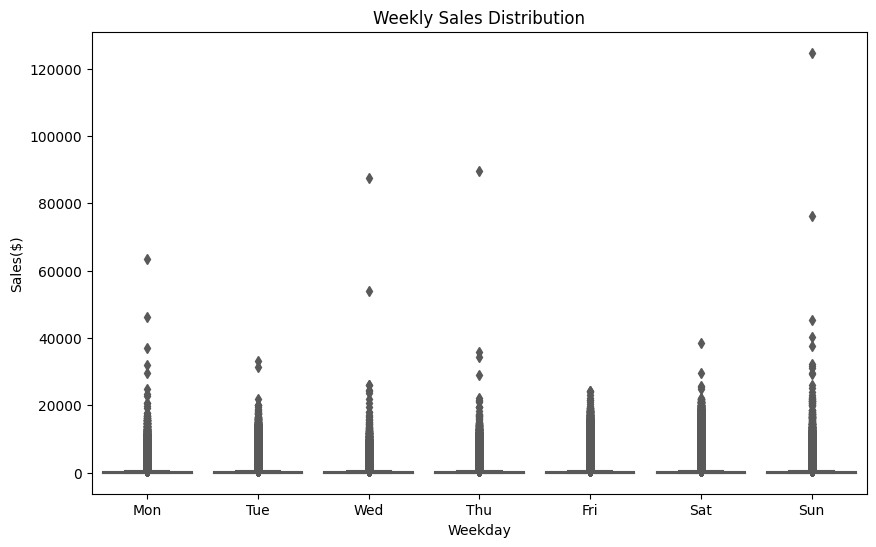

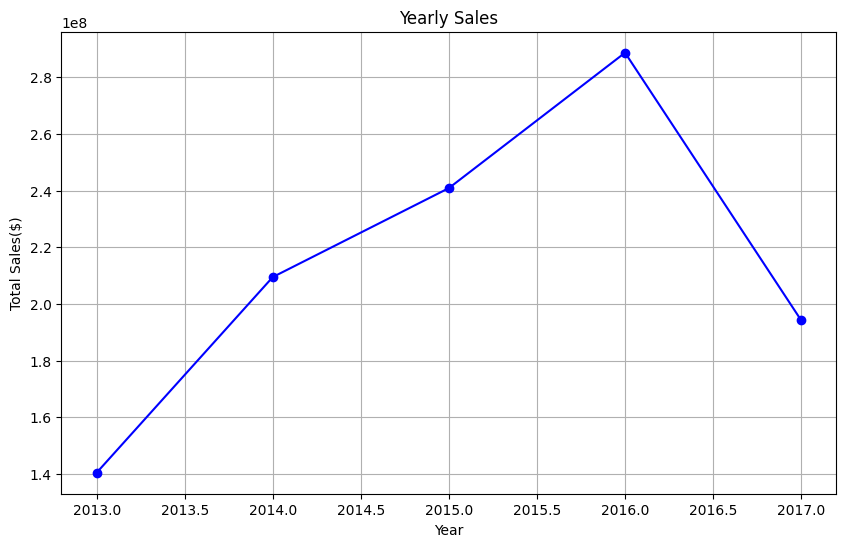

In [374]:

# 1. Time Series Plot of Sales Over Time
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['Sales($)'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales($)')
plt.title('Time Series Plot of Sales Over Time')
plt.grid(True)
plt.show()

# 2. Monthly Sales Bar Plot
monthly_sales = data_train.groupby('Month')['Sales($)'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Total Sales($)')
plt.title('Monthly Sales')
plt.xticks(rotation=45)
plt.show()

# 3. Weekly Sales Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weekday Name', y='Sales($)', data=data_train, palette='Set2')
plt.xlabel('Weekday')
plt.ylabel('Sales($)')
plt.title('Weekly Sales Distribution')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# 4. Sales by Year
yearly_sales = data_train.groupby('Year')['Sales($)'].sum()

plt.figure(figsize=(10, 6))
plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Total Sales($)')
plt.title('Yearly Sales')
plt.grid(True)
plt.show()

The visualizations of date-related features provide several key insights into the sales data:

- **Sales Trends:** The time series chart reveals clear sales trends over the years. There is a consistent upward trend, with periodic increases. Seasonal patterns, such as spikes in sales in the first quarter of 2015, are also evident.

- **Monthly Sales:** Monthly analysis shows that sales tend to be higher in the first half of each year and then experience a decline from September through November. Sales spike significantly in December, possibly due to holiday shopping.

- **Weekly Sales Distribution:** Sales exhibit a weekly pattern. They start the week with a spike on Monday, gradually decline through Friday, and then increase again on Saturday and Sunday, suggesting a weekend shopping trend.

- **Yearly Analysis:** Sales were relatively low in 2013 but showed a substantial increase through 2016. However, there was a drop in sales in 2017, indicating the need to investigate the underlying causes for this decline.

In summary, the data visualizations highlight sales patterns over time, seasonal fluctuations, and weekly shopping trends. These insights can be valuable for making data-driven decisions, optimizing inventory management, and planning sales strategies.


**7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)**

The main difference between RMSLE, RMSE, MSE, and MAE is in how they measure the error between predicted and actual values. RMSLE and RMSE give more weight to larger errors, while MAE treats all errors equally. MAE is often greater than RMSLE and RMSE because it doesn't square the errors, making it less sensitive to outliers and large errors.

### Other Analytical Questions

## 3. MODELLING

## Data Merging
Here we are going to merge the 5 datasets , store data, transactions, oil, events and train data on the common columns.

In [375]:
#Rechecking datasets
data_train.head(5)

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0,2013,1,Tuesday,0.0
2013-01-01,1,1,BABY CARE,0,2013,1,Tuesday,0.0
2013-01-01,2,1,BEAUTY,0,2013,1,Tuesday,0.0
2013-01-01,3,1,BEVERAGES,0,2013,1,Tuesday,0.0
2013-01-01,4,1,BOOKS,0,2013,1,Tuesday,0.0


In [376]:
#Restting the index date to a column
data_train.reset_index(inplace=True)

In [377]:
#rechecking datasets
data_stores.head(5)

,Store_nbr,City,State,Type,Cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [378]:
#rechecking oil data
data_oil.head(5)

,Daily Oil Price,Year,Month,Weekday Name
date,,,,
2013-01-01,93.139999,2013,1,Tuesday
2013-01-02,93.139999,2013,1,Wednesday
2013-01-03,92.970001,2013,1,Thursday
2013-01-04,93.120003,2013,1,Friday
2013-01-07,93.199997,2013,1,Monday


In [379]:
#Restting the index date to a column
data_oil.reset_index(inplace=True)

In [380]:
data_transaction.head(5)

,Store_nbr,Transaction,Year,Month,Weekday Name
date,,,,,
2013-01-01,25,770,2013,1,Tuesday
2013-01-02,1,2111,2013,1,Wednesday
2013-01-02,2,2358,2013,1,Wednesday
2013-01-02,3,3487,2013,1,Wednesday
2013-01-02,4,1922,2013,1,Wednesday


In [381]:
#Restting the index date to a column
data_transaction.reset_index(inplace=True)

In [382]:
#rechecking events data
data_events.head(5)

,Type,Locale,Locale_Name,Description,Transferred,Year,Month,Weekday Name
date,,,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,Friday
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,Sunday
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,Thursday
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,Saturday
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,Saturday


In [383]:
#Restting the index date to a column
data_events.reset_index(inplace=True)

In [384]:
#Restting the index date to a column
data_test.reset_index(inplace=True)

#### Changing datatypes with 64 bits to 32 bits-- numerical columns
This is to create memory space as we are encountering Memory error when merging the datasets 

In [385]:
#checking the datatypes for data-train
data_train.dtypes

date            datetime64[ns]
ID                       int64
Store_nbr                int64
Family                  object
Onpromotion              int32
Year                     int32
Month                    int32
Weekday Name            object
Sales($)               float64
dtype: object

In [386]:
# Convert numerical columns to 32-bit in data_train
numerical_columns = data_train.select_dtypes(include=['float64', 'int64']).columns
data_train[numerical_columns] = data_train[numerical_columns].astype(np.float32)

In [387]:
#recheck the datatypes again
data_train.dtypes

date            datetime64[ns]
ID                     float32
Store_nbr              float32
Family                  object
Onpromotion              int32
Year                     int32
Month                    int32
Weekday Name            object
Sales($)               float32
dtype: object

In [388]:
#Checking datatypes for data_stores
data_stores.dtypes

Store_nbr     int64
City         object
State        object
Type         object
Cluster       int64
dtype: object

In [389]:
# Convert numerical columns to 32-bit in stores
numerical_columns = data_stores.select_dtypes(include=['float64', 'int64']).columns
data_stores[numerical_columns] = data_stores[numerical_columns].astype(np.float32)

In [390]:
#recheck the dtypes again
data_stores.dtypes

Store_nbr    float32
City          object
State         object
Type          object
Cluster      float32
dtype: object

In [391]:
#checking datatypes for oil dataset
data_oil.dtypes

date               datetime64[ns]
Daily Oil Price           float64
Year                        int32
Month                       int32
Weekday Name               object
dtype: object

In [392]:
# Convert numerical columns to 32-bit in oil
numerical_columns = data_oil.select_dtypes(include=['float64', 'int64']).columns
data_oil[numerical_columns] = data_oil[numerical_columns].astype(np.float32)

In [393]:
#recheking data_oil dtypes
data_oil.dtypes

date               datetime64[ns]
Daily Oil Price           float32
Year                        int32
Month                       int32
Weekday Name               object
dtype: object

In [394]:
#checking datatypes for transaction data
data_transaction.dtypes

date            datetime64[ns]
Store_nbr                int64
Transaction              int64
Year                     int32
Month                    int32
Weekday Name            object
dtype: object

In [395]:
# Convert numerical columns to 32-bit in transaction
numerical_columns = data_transaction.select_dtypes(include=['float64', 'int64']).columns
data_transaction[numerical_columns] = data_transaction[numerical_columns].astype(np.float32)

In [396]:
#rechecking data_transaction dtypes
data_transaction.dtypes

date            datetime64[ns]
Store_nbr              float32
Transaction            float32
Year                     int32
Month                    int32
Weekday Name            object
dtype: object

In [397]:
#checking datatypes for events data
data_events.dtypes

date            datetime64[ns]
Type                    object
Locale                  object
Locale_Name             object
Description             object
Transferred               bool
Year                     int32
Month                    int32
Weekday Name            object
dtype: object

In [398]:
# Convert numerical columns to 32-bit in events
numerical_columns = data_events.select_dtypes(include=['float64', 'int64']).columns
data_events[numerical_columns] = data_events[numerical_columns].astype(np.float32)

In [399]:
# Rechecking datatypes in the events dataset
data_events.dtypes

date            datetime64[ns]
Type                    object
Locale                  object
Locale_Name             object
Description             object
Transferred               bool
Year                     int32
Month                    int32
Weekday Name            object
dtype: object

The numerical columns datatypes have been changed to 32bits, lets go ahead and merge the datasets for data modelling

In [400]:
#Lets drop the year, month, weekday name  columns in train data, events, oil and transaction
# Drop columns for 'Year', 'Weekday Name', and 'Month' from data_oil DataFrame
data_oil.drop(['Year', 'Weekday Name', 'Month'], axis=1, inplace= True)

# Drop columns for 'Year', 'Weekday Name', and 'Month' from data_events DataFrame
data_events.drop(['Year', 'Weekday Name', 'Month'], axis=1, inplace = True)

# Drop columns for 'Year', 'Weekday Name', and 'Month' from data_train DataFrame
data_train.drop(['Year', 'Weekday Name', 'Month'], axis=1, inplace=True)

# Drop columns for 'Year', 'Weekday Name', and 'Month' from data_transaction DataFrame
data_transaction.drop(['Year', 'Weekday Name', 'Month'], axis=1, inplace=True)

In [401]:
# Define a function that check the matching columns across all the dataset 

# Define a Class that assigns the name to the Dataset
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name

# Define a function that output the matching pairs
def find_matching_columns_in_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]

                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [402]:
# Define the dataset names
datasets = [
    (data_oil, 'Oil'),
    (data_events, 'Holidays Events'),
    (data_stores, 'Stores'),
    (data_transaction, 'Transactions'),
    (data_train, 'Train'),
    (data_test, 'Test'),
]

# Apply the function to check the pairs
find_matching_columns_in_pairs(datasets)

Matching columns between Oil and Holidays Events: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays Events and Stores: ['Type']
Matching columns between Holidays Events and Transactions: ['date']
Matching columns between Holidays Events and Train: ['date']
Matching columns between Holidays Events and Test: ['date']
Matching columns between Stores and Transactions: ['Store_nbr']
Matching columns between Stores and Train: ['Store_nbr']
Matching columns between Stores and Test: ['Store_nbr']
Matching columns between Transactions and Train: ['date', 'Store_nbr']
Matching columns between Transactions and Test: ['date', 'Store_nbr']
Matching columns between Train and Test: ['date', 'ID', 'Store_nbr', 'Family', 'Onpromotion']


In [403]:
# Define a function that compares the two dates and also check the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [404]:
#Apply the function to compare for Transaction and Train
compare_result_train= date_comparison(data_transaction['date'], data_train['date'])

# print
pd.DataFrame(compare_result_train)

,Common,Uncommon,Date Range 1,Date Range 2
0,1682,2,2013-01-01,2013-01-01
1,1682,2,2017-08-15,2017-08-15


In [405]:
# Apply the function to compare for Transaction and Test
compare_result_test= date_comparison(data_transaction['date'], data_test['date'])

# print
pd.DataFrame(compare_result_test)

,Common,Uncommon,Date Range 1,Date Range 2
0,0,1698,2013-01-01,2017-08-16
1,0,1698,2017-08-15,2017-08-31


In [406]:
# Merge the Oil data to the Train and Test
train = data_train.merge(data_oil, on=['date'])
final_test = data_test.merge(data_oil, on=['date'])

In [407]:
train.head(5)

,date,ID,Store_nbr,Family,Onpromotion,Sales($),Daily Oil Price
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0,0.0,93.139999
1,2013-01-01,1.0,1.0,BABY CARE,0,0.0,93.139999
2,2013-01-01,2.0,1.0,BEAUTY,0,0.0,93.139999
3,2013-01-01,3.0,1.0,BEVERAGES,0,0.0,93.139999
4,2013-01-01,4.0,1.0,BOOKS,0,0.0,93.139999


In [408]:
# Merge holidays events, stores and transactions to the Train
train = train.merge(data_stores, on=['Store_nbr'])
train = train.merge(data_events, on=['date'])
train = train.merge(data_transaction, on=['date', 'Store_nbr'])

Data_merged. Lets check the nature and missing values and drop not needed columns

In [409]:
#rechecking if the data is merged 
train.tail(10)

,date,ID,Store_nbr,Family,Onpromotion,Sales($),Daily Oil Price,City,State,Type_x,Cluster,Type_y,Locale,Locale_Name,Description,Transferred,Transaction
322037,2017-08-15,3000878.0,9.0,MAGAZINES,0,11.000000,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322038,2017-08-15,3000879.0,9.0,MEATS,0,449.227997,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322039,2017-08-15,3000880.0,9.0,PERSONAL CARE,11,522.000000,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322040,2017-08-15,3000881.0,9.0,PET SUPPLIES,0,6.000000,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322041,2017-08-15,3000882.0,9.0,PLAYERS AND ELECTRONICS,0,6.000000,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322042,2017-08-15,3000883.0,9.0,POULTRY,0,438.132996,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322043,2017-08-15,3000884.0,9.0,PREPARED FOODS,1,154.552994,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322044,2017-08-15,3000885.0,9.0,PRODUCE,148,2419.729004,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322045,2017-08-15,3000886.0,9.0,SCHOOL AND OFFICE SUPPLIES,8,121.000000,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0
322046,2017-08-15,3000887.0,9.0,SEAFOOD,0,16.000000,47.57,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0


In [410]:
#checking missing values
train.isna().sum()

date               0
ID                 0
Store_nbr          0
Family             0
Onpromotion        0
Sales($)           0
Daily Oil Price    0
City               0
State              0
Type_x             0
Cluster            0
Type_y             0
Locale             0
Locale_Name        0
Description        0
Transferred        0
Transaction        0
dtype: int64

There are no missing values the merged train set. Lets drop unnecesssary columns

In [411]:
#Store Train df in a final_train df
final_train = train

In [412]:
#lets check the columns for train data
final_train.columns

Index(['date', 'ID', 'Store_nbr', 'Family', 'Onpromotion', 'Sales($)',
       'Daily Oil Price', 'City', 'State', 'Type_x', 'Cluster', 'Type_y',
       'Locale', 'Locale_Name', 'Description', 'Transferred', 'Transaction'],
      dtype='object')

In [413]:
#lets check the columns for test data
final_test.columns

Index(['date', 'ID', 'Store_nbr', 'Family', 'Onpromotion', 'Year', 'Month',
       'Weekday Name', 'Daily Oil Price'],
      dtype='object')

In [414]:
# List of columns to drop on train
columns_to_drop = ['City', 'State', 'Type_x','Type_y','Locale', 'Locale_Name', 'Description']

# Drop the columns from the merged train set
final_train = train.drop(columns=columns_to_drop)

In [415]:
# List of columns to drop on test
columns_to_drop = [
    'Year', 'Month', 'Weekday Name'
]

# Drop the columns from the merged train set
final_test = final_test.drop(columns=columns_to_drop)

In [416]:
#rechecking ready train data set ready for encoding and scaling
final_train.head()

,date,ID,Store_nbr,Family,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction
0,2013-01-01,561.0,25.0,AUTOMOTIVE,0,0.0,93.139999,1.0,False,770.0
1,2013-01-01,562.0,25.0,BABY CARE,0,0.0,93.139999,1.0,False,770.0
2,2013-01-01,563.0,25.0,BEAUTY,0,2.0,93.139999,1.0,False,770.0
3,2013-01-01,564.0,25.0,BEVERAGES,0,810.0,93.139999,1.0,False,770.0
4,2013-01-01,565.0,25.0,BOOKS,0,0.0,93.139999,1.0,False,770.0


#### - **Perform a Stationarity Test using KUPPS Test**
To check if our merged train set is stationary or not.

Null Hypothesis (H0): The time series is stationary around a deterministic trend, indicating the presence of stationarity.

Alternative Hypothesis (H1): The time series is not stationary, suggesting the presence of a unit root or non-stationarity.

In [417]:
# Define a function to perform the KPSS test
def kpss_test(timeseries):
    statistic, p_value, lags, critical_values = kpss(timeseries)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    
    if p_value < 0.05:
        print('Result: The time series is not stationary (reject H0)')
    else:
        print('Result: The time series is stationary (fail to reject H0)')

# Perform the KPSS test on your time series data
kpss_test(final_train['Sales($)'])


KPSS Statistic: 20.796042213024634
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Result: The time series is not stationary (reject H0)


- **First Order Differencing to stationarize our target column**

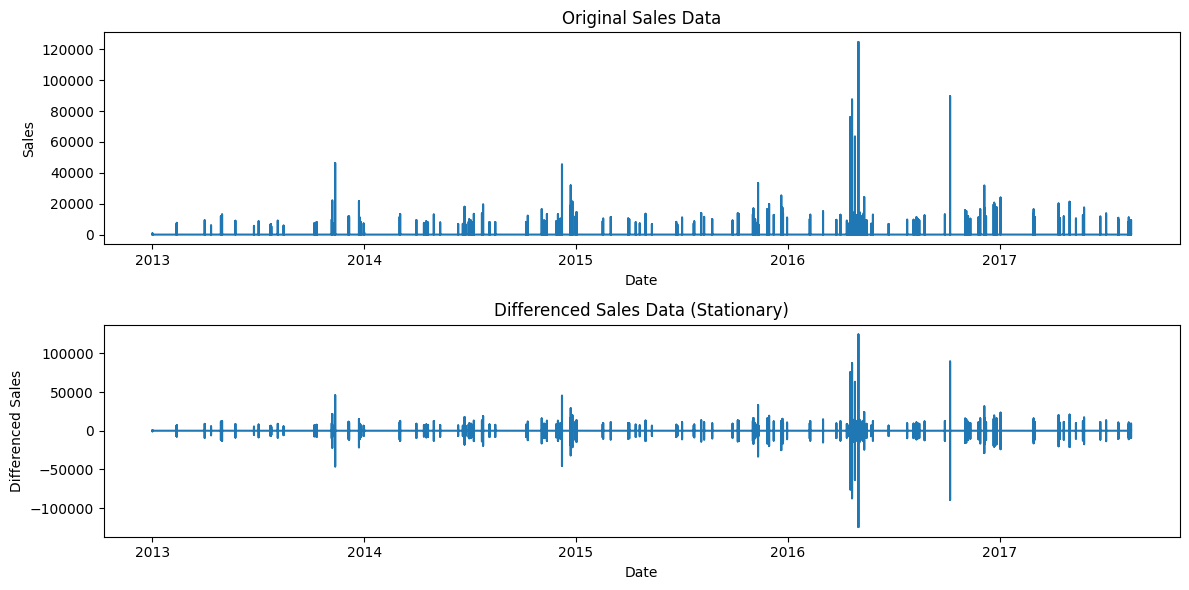

In [418]:
# Perform first-order differencing
final_train['stationary_sales'] = final_train['Sales($)'].diff()

# Drop NaN values from the differenced series
final_train = final_train.dropna(subset=['stationary_sales'])

# Plot the original and differenced series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(final_train['date'], final_train['Sales($)'])
plt.title('Original Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.subplot(2, 1, 2)
plt.plot(final_train['date'], final_train['stationary_sales'])
plt.title('Differenced Sales Data (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')

plt.tight_layout()
plt.show()

- Lets test the Stationarity again on the differenced sales column


In [419]:
# Define a function to perform the KPSS test
def kpss_test(timeseries):
    statistic, p_value, lags, critical_values = kpss(timeseries)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    
    if p_value < 0.05:
        print('Result: The time series is not stationary (reject H0)')
    else:
        print('Result: The time series is stationary ')

# Perform the KPSS test on your time series data
kpss_test(final_train['stationary_sales'])

KPSS Statistic: 0.002312448062858374
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Result: The time series is stationary 


### Deseasonalized time series data for sales
We take the seasonal component out of the original time series in order to deseasonalize it using the decomposition result. By doing this, the seasonal variance will be eliminated, leaving only the deseasonalized data.

In [420]:
# Perform additive decomposition
result_add = seasonal_decompose(final_train['Sales($)'], model='additive', extrapolate_trend='freq', period=12)

# Subtract the seasonal component from the original time series
deseasonalized_sales = result_add.observed - result_add.seasonal

In [421]:
# Apply the deseasonalized sales to the sales data
final_train['Sales($)'] = deseasonalized_sales

In [422]:
#rechecking the info
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322046 entries, 1 to 322046
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              322046 non-null  datetime64[ns]
 1   ID                322046 non-null  float32       
 2   Store_nbr         322046 non-null  float32       
 3   Family            322046 non-null  object        
 4   Onpromotion       322046 non-null  int32         
 5   Sales($)          322046 non-null  float64       
 6   Daily Oil Price   322046 non-null  float32       
 7   Cluster           322046 non-null  float32       
 8   Transferred       322046 non-null  bool          
 9   Transaction       322046 non-null  float32       
 10  stationary_sales  322046 non-null  float32       
dtypes: bool(1), datetime64[ns](1), float32(6), float64(1), int32(1), object(1)
memory usage: 18.7+ MB


### 3.1 FeatureEngineering Scaling and Feature Encoding

Here we are using Data Stored as dataframe - **final_train** and **final_test**, to create new feature - Categorizing the family Column encode the categorical columns and scale the numerical columns then do data splitting.

### Categorization.
We are going to Categorize the family column in bothe train and test data into on the family and holiday column to minimize number of columns created when encoded have been done.

#### <u>Categorizing the Family Column</u>

- FOOD: bread/bakery, dairy, deli, eggs, frozen foods, grocery i, grocery ii, meats, poultry, prepared foods, produce, seafood

- BEVERAGES: beverages, liquor,wine,beer

- HOME and kitchen: home and kitchen i, home and kitchen ii, home appliances, home care

- PERSONAL care: beauty, baby care, personal care

- CLOTHING: ladieswear, lingerie

- OTHERS: automotive, celebration, cleaning, hardware, lawn and garden, magazines, pet supplies, players and electronics, school and office supplies

#### <u>Categorizing the Holiday Type Column</u>
Here we categorize it **Workday** and **Holiday**

If the value of ‘Holiday_type’ is one of the specified strings ‘Holiday’, ‘Additional’, ‘Event’, ‘Transfer’, or ‘Bridge’, then the new value of ‘Holiday_type’ will be ‘Holiday’. If it is not one of those strings, then the new value will be ‘Workday’.

In [423]:
#Implement the grouping of product family on the actual family attribute. 

final_train['Family'] = final_train['Family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

In [424]:
#Implement the grouping of product family on the actual family attribute.
final_test['Family'] = final_test['Family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

In [425]:
#Implement the grouping of holiday type on the actual holiday type attribute.
#final_train['Type_y'] = np.where(final_train['Type_y'].isin(['Holiday', 'Additional', 'Event', 'Transfer', 'Bridge']), 'Holiday', 'Workday')

In [426]:
#rechecking the if the categorization has been achieved
final_train.head(4)

,date,ID,Store_nbr,Family,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction,stationary_sales
1,2013-01-01,562.0,25.0,Personal Care,0,156.635509,93.139999,1.0,False,770.0,0.0
2,2013-01-01,563.0,25.0,Personal Care,0,245.741654,93.139999,1.0,False,770.0,2.0
3,2013-01-01,564.0,25.0,Beverages,0,410.242453,93.139999,1.0,False,770.0,808.0
4,2013-01-01,565.0,25.0,Others,0,153.813410,93.139999,1.0,False,770.0,-810.0


The Categorization of the family column has been achieved lets encode the OnPromotion to show the binary numbers. Where the value is greater than 1 replace it with 1. 

In [427]:
#Lets encode the Onpromotion column on both test and train data
# Encode the 'Onpromotion' column in the train data
final_train['Onpromotion'] = (final_train['Onpromotion'] >= 1).astype('int32')

# Encode the 'Onpromotion' column in the test data
final_test['Onpromotion'] = (final_test['Onpromotion'] >= 1).astype('int32')

In [428]:
#checking if the encoding has been achieved on all
final_train['Onpromotion'].value_counts(),final_test['Onpromotion'].value_counts()

(Onpromotion
 0    238595
 1     83451
 Name: count, dtype: int64,
 Onpromotion
 0    11916
 1     9468
 Name: count, dtype: int64)

Encoding Transferred column: Changing the transferred column in the final_train from Boolen to Int32, binary.

In [429]:
#changing Transferred column from boolen to binary
final_train['Transferred'] = final_train['Transferred'].astype('int32')

In [430]:
#checking if the encoding has been achieved on all
final_train['Transferred'].value_counts()

Transferred
0    308351
1     13695
Name: count, dtype: int64

encoding on the Onpromotion column(in both Final_train and Final_test) and Transferred column (in final_train) has been achieved lets now encode the categorical columns using the one encoder

- **Encoding the Categorical columns**
Here we are going to Encode the categorical columns on both train data and test sets as some Model Algorithms are sensitive to non numerical data, we are going to use **OneHotEncoder**

In [431]:
#Selecting only numerical columns and setting a named variable for both Train data and X_test
num_train_data = final_train.select_dtypes(exclude="object")
num_X_test = final_test.select_dtypes(exclude="object")
#num_test = num_X_test.drop(columns=['ID','Year','Month'])
num_X_test.head()

,date,ID,Store_nbr,Onpromotion,Daily Oil Price
0,2017-08-16,3000888,1,0,46.799999
1,2017-08-16,3000889,1,0,46.799999
2,2017-08-16,3000890,1,1,46.799999
3,2017-08-16,3000891,1,1,46.799999
4,2017-08-16,3000892,1,0,46.799999


In [432]:
#Dealing will categorical columns  on the train and X-test Sets
cat_train_data = final_train.select_dtypes(include="object")

#for Test data
cat_X_test = final_test.select_dtypes(include="object")
cat_train_data.head()

,Family
1,Personal Care
2,Personal Care
3,Beverages
4,Others
5,Food


In [433]:
#Encoding Categorical Train Set
#Creating an instance of OneHotEncode
enc= OneHotEncoder()
# model to learn from Categorical X train data
enc.fit(cat_train_data)

OneHotEncoder()

All columns categorized as categorical have been selected for both train data and Test set,  the Sales column as it not in the Xtest data but its a numerical column which has no effect on encoding step

In [434]:
# Transform the Categorical train data
tct_train_data = pd.DataFrame(enc.transform(cat_train_data).toarray(), index=cat_train_data.index, columns=enc.get_feature_names_out(input_features=cat_train_data.columns))

# Transform the Categorical X_test data
tct_X_test = pd.DataFrame(enc.transform(cat_X_test).toarray(), index=cat_X_test.index, columns=enc.get_feature_names_out(input_features=cat_X_test.columns))

# Display the head of tct_train_data
tct_train_data.head(5)

,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,Family_Others,Family_Personal Care
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0


In [435]:
#Combining Categorical and number tranformed Xtrain and Xtest sets
comb_train_data= pd.merge(left=num_train_data,right=tct_train_data, how='outer',left_index =True,right_index=True)
comb_X_test= pd.merge(left=num_X_test,right=tct_X_test, how='outer',left_index =True,right_index=True)
comb_train_data.head()

,date,ID,Store_nbr,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction,stationary_sales,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,Family_Others,Family_Personal Care
1,2013-01-01,562.0,25.0,0,156.635509,93.139999,1.0,0,770.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
2,2013-01-01,563.0,25.0,0,245.741654,93.139999,1.0,0,770.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,2013-01-01,564.0,25.0,0,410.242453,93.139999,1.0,0,770.0,808.000000,1.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,565.0,25.0,0,153.813410,93.139999,1.0,0,770.0,-810.000000,0.0,0.0,0.0,0.0,1.0,0.0
5,2013-01-01,566.0,25.0,0,429.353000,93.139999,1.0,0,770.0,180.589005,0.0,0.0,1.0,0.0,0.0,0.0


In [436]:
#Data-sets to be used for modelling
final_train = comb_train_data
final_test = comb_X_test

##### changing column data types to 32 int to match all columns for both encoded test and train date columns

In [437]:
#rechecking datatype
final_train.dtypes

date                       datetime64[ns]
ID                                float32
Store_nbr                         float32
Onpromotion                         int32
Sales($)                          float64
Daily Oil Price                   float32
Cluster                           float32
Transferred                         int32
Transaction                       float32
stationary_sales                  float32
Family_Beverages                  float64
Family_Clothing                   float64
Family_Food                       float64
Family_Home and Kitchen           float64
Family_Others                     float64
Family_Personal Care              float64
dtype: object

In [438]:
# List of columns to change to float32
float_columns = ['Family_Beverages','Family_Clothing','Family_Food','Family_Home and Kitchen','Family_Others','Family_Personal Care']

# Change specified columns to float32
final_train[float_columns] = final_train[float_columns].astype('float32')
final_test[float_columns] = final_test[float_columns].astype('float32')

final_train.dtypes

date                       datetime64[ns]
ID                                float32
Store_nbr                         float32
Onpromotion                         int32
Sales($)                          float64
Daily Oil Price                   float32
Cluster                           float32
Transferred                         int32
Transaction                       float32
stationary_sales                  float32
Family_Beverages                  float32
Family_Clothing                   float32
Family_Food                       float32
Family_Home and Kitchen           float32
Family_Others                     float32
Family_Personal Care              float32
dtype: object

- #### Checking Colinearlity of the variables
here we going to plot correlation heatmap to check the correlations of the variables. This will help us to drop the redundant variables

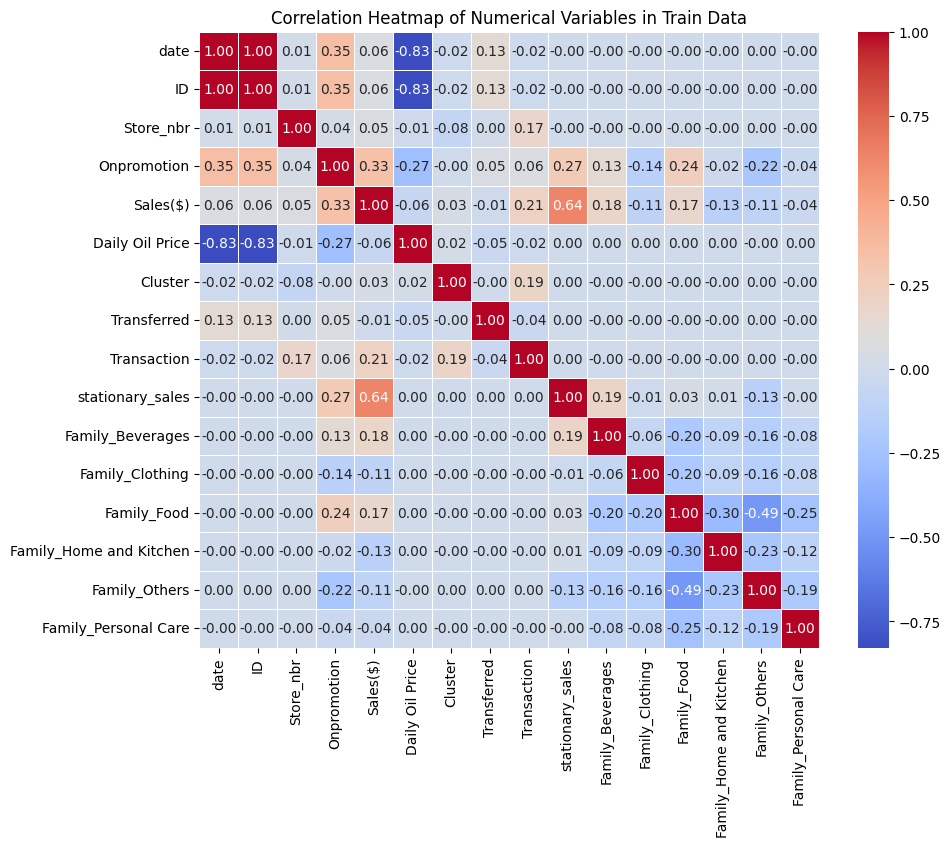

In [439]:
# Calculate the correlation matrix
correlation_matrix = final_train.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add labels and title
plt.title("Correlation Heatmap of Numerical Variables in Train Data")
plt.show()

From the heat map, ID and Date have strong correlation with each other, we need to drop ID column at this point as it its will cause our model to overfit. This should be done as well on the Final Test dataframe.

In [440]:
#Drop the ID column on bothe final_train and final_test
# List of columns to drop on train
columns_to_drop = ['ID','stationary_sales']

# Drop the columns from the final train set
final_train = final_train.drop(columns=columns_to_drop)

# Drop the columns from the final test set
column_to_drop = ['ID']

final_test = final_test.drop(columns=column_to_drop)
final_train.head(5)

,date,Store_nbr,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,Family_Others,Family_Personal Care
1,2013-01-01,25.0,0,156.635509,93.139999,1.0,0,770.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2013-01-01,25.0,0,245.741654,93.139999,1.0,0,770.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2013-01-01,25.0,0,410.242453,93.139999,1.0,0,770.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,25.0,0,153.813410,93.139999,1.0,0,770.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2013-01-01,25.0,0,429.353000,93.139999,1.0,0,770.0,0.0,0.0,1.0,0.0,0.0,0.0


- #### **Getting the Datefeatures**
Here we will get date features for our model to learn from the time series information - Year, month, week, day

In [441]:
# Define a fucnction to get date features
def getDatefeatures(df,date):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_start_month'] = df['date'].dt.is_month_start.astype('int32')
    df['is_end_month'] = df['date'].dt.is_month_end.astype('int32')
    df['is_start_year'] = df['date'].dt.is_year_start.astype('int32')
    df['is_end_year'] = df['date'].dt.is_year_end.astype('int32')
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype('int32')  # 5 and 6 represent Saturday and Sunday
    return df

In [442]:
#Getting the date features
final_train = getDatefeatures(final_train, 'date')
final_test = getDatefeatures(final_test, 'date')
final_test.head(5)

,date,Store_nbr,Onpromotion,Daily Oil Price,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,Family_Others,Family_Personal Care,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
0,2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,1.0,0.0,2017,8,16,2,228,0,0,0,0,0
1,2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,0.0,1.0,2017,8,16,2,228,0,0,0,0,0
2,2017-08-16,1,1,46.799999,0.0,0.0,0.0,0.0,0.0,1.0,2017,8,16,2,228,0,0,0,0,0
3,2017-08-16,1,1,46.799999,1.0,0.0,0.0,0.0,0.0,0.0,2017,8,16,2,228,0,0,0,0,0
4,2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,1.0,0.0,2017,8,16,2,228,0,0,0,0,0


In [443]:
#checking datatypes again
final_train.dtypes

date                       datetime64[ns]
Store_nbr                         float32
Onpromotion                         int32
Sales($)                          float64
Daily Oil Price                   float32
Cluster                           float32
Transferred                         int32
Transaction                       float32
Family_Beverages                  float32
Family_Clothing                   float32
Family_Food                       float32
Family_Home and Kitchen           float32
Family_Others                     float32
Family_Personal Care              float32
year                                int32
month                               int32
day                                 int32
weekday                             int32
day_of_year                         int32
is_start_month                      int32
is_end_month                        int32
is_start_year                       int32
is_end_year                         int32
is_weekend                        

#### **Scaling**
Here we are going to scale all features using MinScaler

In [444]:
#Define columns to scale
cols_to__scale = ['Family_Beverages','Family_Clothing','Family_Food','Family_Home and Kitchen','Family_Others','Family_Personal Care',
'year','month','day','weekday','day_of_year','is_start_month','is_end_month','is_start_year','is_end_year','is_weekend']

#Initialize the scaler
scaler = MinMaxScaler()
final_train[cols_to__scale] = scaler.fit_transform(final_train[cols_to__scale])
final_train.head(5)

,date,Store_nbr,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction,Family_Beverages,Family_Clothing,...,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
1,2013-01-01,25.0,0,156.635509,93.139999,1.0,0,770.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2,2013-01-01,25.0,0,245.741654,93.139999,1.0,0,770.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
3,2013-01-01,25.0,0,410.242453,93.139999,1.0,0,770.0,1.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
4,2013-01-01,25.0,0,153.813410,93.139999,1.0,0,770.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
5,2013-01-01,25.0,0,429.353000,93.139999,1.0,0,770.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0


## 3.2 Data Splitting
The dataset will then be split into training and evaluation datasets. The machine learning model is trained using the training dataset, and its performance is assessed using the validation dataset. 
But first is filtering the dataset without outliers for modelling, at first we encountered model over fitting and now we had to recheck the data preprocessing stage again

In [445]:
#checking the shape of final train
final_train.shape

(322046, 24)

- #### Checking Outliers and removing them in final_train
This will handle the model overfitting issue we have encountered during the modelling at first

In [446]:
# Calculate the IQR (Interquartile Range) for 'stationary_sales'
Q1 = final_train['Sales($)'].quantile(0.25)
Q3 = final_train['Sales($)'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers and create a mask to filter them
outliers_mask = (final_train['Sales($)'] < lower_bound) | (final_train['Sales($)'] > upper_bound)

# Create a new DataFrame without outliers
final_train_no_outliers = final_train[~outliers_mask]

# Summary statistics after removing outliers
summary_stats_no_outliers = final_train_no_outliers['Sales($)'].describe()

# Display summary statistics
print("Summary Statistics without Outliers:")
print(summary_stats_no_outliers)

Summary Statistics without Outliers:
count    203981.000000
mean        245.065991
std         127.784071
min        -166.209998
25%         161.154384
50%         247.710191
75%         277.710191
max         650.337505
Name: Sales($), dtype: float64


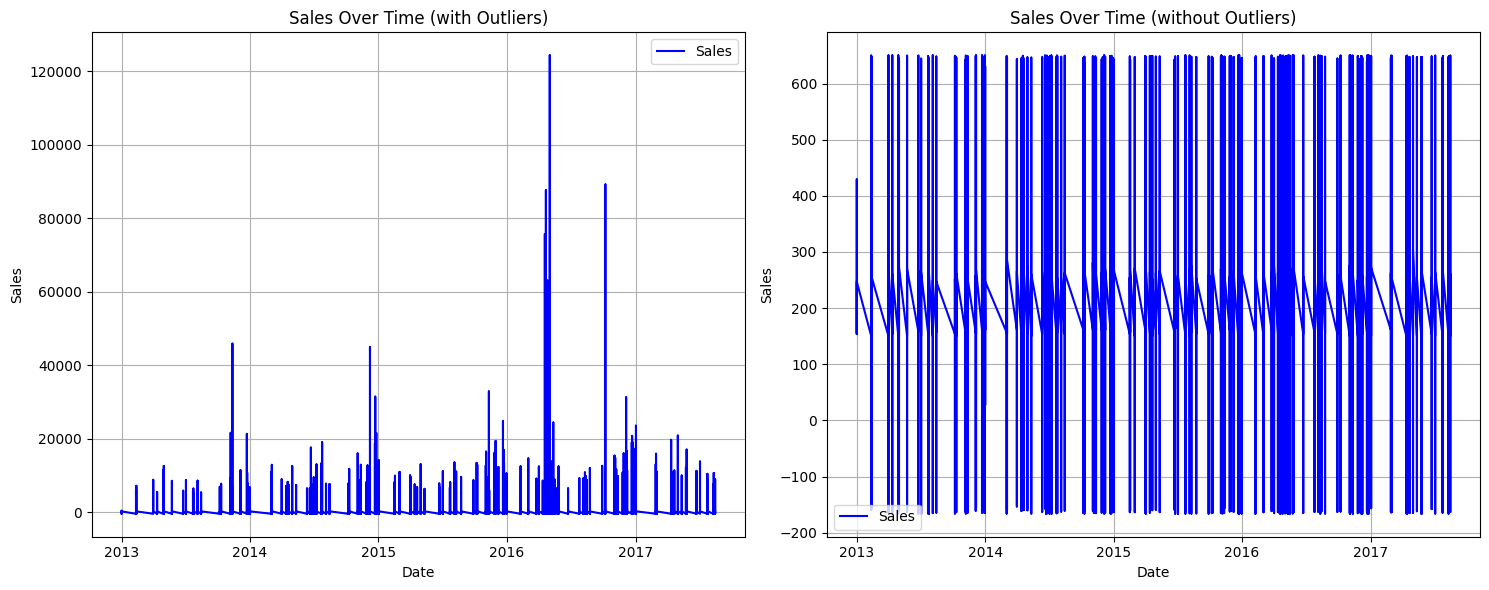

In [447]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Sales column with outliers
ax1.plot(final_train['date'], final_train['Sales($)'], label='Sales', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.set_title('Sales Over Time (with Outliers)')
ax1.grid(True)
ax1.legend()

# Second subplot: Sales column without outliers
ax2.plot(final_train_no_outliers['date'], final_train_no_outliers['Sales($)'], label='Sales', color='blue')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
ax2.set_title('Sales Over Time (without Outliers)')
ax2.grid(True)
ax2.legend()

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the subplots
plt.show()

In [448]:
#setting the date as index for bothe train and test data
final_train_no_outliers= final_train_no_outliers.set_index('date')
final_test = final_test.set_index('date')
final_train_no_outliers.head(5)

,Store_nbr,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction,Family_Beverages,Family_Clothing,Family_Food,...,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,25.0,0,156.635509,93.139999,1.0,0,770.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,245.741654,93.139999,1.0,0,770.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,410.242453,93.139999,1.0,0,770.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,153.813410,93.139999,1.0,0,770.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,429.353000,93.139999,1.0,0,770.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0


In [449]:
final_train_no_outliers.head(5)

,Store_nbr,Onpromotion,Sales($),Daily Oil Price,Cluster,Transferred,Transaction,Family_Beverages,Family_Clothing,Family_Food,...,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,25.0,0,156.635509,93.139999,1.0,0,770.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,245.741654,93.139999,1.0,0,770.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,410.242453,93.139999,1.0,0,770.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,153.813410,93.139999,1.0,0,770.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,429.353000,93.139999,1.0,0,770.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0


In [450]:
# Calculate the number of rows in the data
n_rows = final_train_no_outliers.shape[0]

# Calculate the split point
split_point = int(n_rows * 0.7)

# Select the first 70% of the rows as the training data
train_data = final_train_no_outliers.iloc[:split_point]

# Select the remaining rows as the validation data
validation_data = final_train_no_outliers.iloc[split_point:]

In [451]:
#Rechecking the split sets
train_data.shape, validation_data.shape

((142786, 23), (61195, 23))

### Splitting datasets to Variables, X and Y for both Validation and Train Sets for non-static models

In [452]:
#Lets reindex the Date column and select our X-train and Y-train
#train_data1 = train_data['date'].reset_index()
X_train =train_data.drop(columns=["Sales($)"])
y_train=train_data["Sales($)"]
#Lets reindex the Date column and select our X-Validation and Y-validation
#validation_data = validation_data['date].reset_index()
X_validation =validation_data.drop(columns=["Sales($)"])
y_validation=validation_data["Sales($)"]

#Rechecking the sets
X_train.head(5)

,Store_nbr,Onpromotion,Daily Oil Price,Cluster,Transferred,Transaction,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,...,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,25.0,0,93.139999,1.0,0,770.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,93.139999,1.0,0,770.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,93.139999,1.0,0,770.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,93.139999,1.0,0,770.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0
2013-01-01,25.0,0,93.139999,1.0,0,770.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.25,0.0,1.0,0.0,1.0,0.0,0.0


## 3.3 ML Modeling
Here we are going to build train and evaluate 5 regressions models. Some are Static models where we will need to pass in entire train and validation data without splitting to X and Y variables 

#### Checking for relationship between our data_point - in the train data

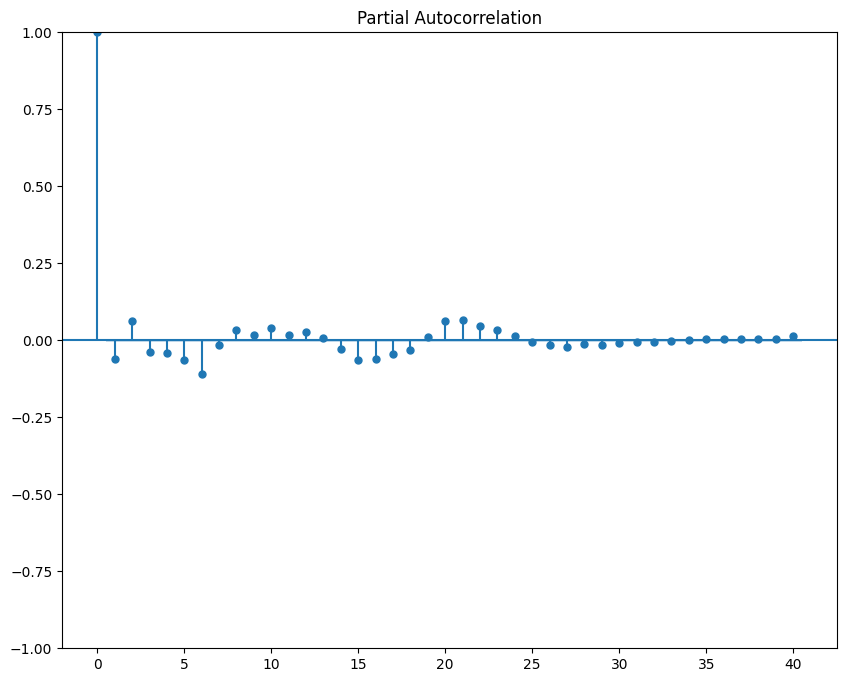

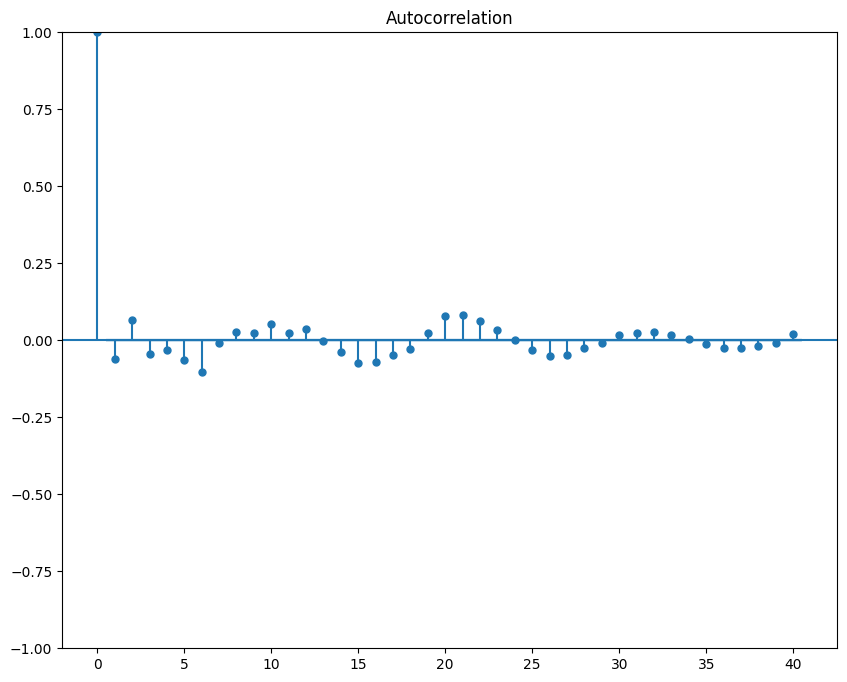

In [453]:
#Checking data points for the training set
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
pacf = plot_pacf(y_train, lags =40)
acf = plot_acf(y_train, lags =40)

In [454]:
# Define a list to store trained models
trained_models = []

### Model 1: AutoRegression(AR)
AutoReg is a time series forecasting model that predicts future values based on a linear combination of past values, with the order of the model ('p') specifying how many past values are used for prediction. It's useful for tasks like stock price prediction and demand forecasting.

In [455]:
#Creating and training  the model
ar_model = AutoReg(y_train, lags=10)  # Adjust lags as needed
ar_model_fit = ar_model.fit()
trained_models.append(ar_model_fit)

In [456]:
#Checking the trained model summary
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               Sales($)   No. Observations:               142786
Model:                    AutoReg(10)   Log Likelihood             -892355.118
Method:               Conditional MLE   S.D. of innovations            125.348
Date:                Sun, 17 Sep 2023   AIC                        1784734.237
Time:                        21:16:15   BIC                        1784852.665
Sample:                            10   HQIC                       1784769.611
                               142786                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          289.4222      2.351    123.102      0.000     284.814     294.030
Sales($).L1     -0.0677      0.003    -25.605      0.000      -0.073      -0.063
Sales($).L2      0.0564      0.003     21.283      0.000       0.051       0.062
Sales($).L3     -0.0358      0.003    -13.486      0.000      -0.041      -0.031
Sales($).L4     -0.0317      0.003    -11.944      0.000      -0.037      -0.027
Sales($).L5     -0.0655      0.003    -24.823      0.000      -0.071      -0.060
Sales($).L6     -0.1107      0.003    -41.944      0.000      -0.116      -0.106
Sales($).L7     -0.0143      0.003     -5.370      0.000      -0.019      -0.009
Sales($).L8      0.0306      0.003     11.517      0.000       0.025       0.036
Sales($).L9      0.0198      0.003      7.487      0.000       0.015       0.025
Sales($).L10     0.0407      0.003     15.376      0.000       0.035       0.046
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9899           -0.7226j            1.2256           -0.1004
AR.2             0.9899           +0.7226j            1.2256            0.1004
AR.3             1.4536           -0.0000j            1.4536           -0.0000
AR.4            -1.3898           -0.0000j            1.3898           -0.5000
AR.5            -1.1157           -0.7496j            1.3442           -0.4058
AR.6            -1.1157           +0.7496j            1.3442            0.4058
AR.7             0.2494           -1.4068j            1.4288           -0.2221
AR.8             0.2494           +1.4068j            1.4288            0.2221
AR.9            -0.3995           -1.4276j            1.4824           -0.2934
AR.10           -0.3995           +1.4276j            1.4824            0.2934
------------------------------------------------------------------------------
"""

- Evaluating the model

In [457]:
#Predicting the Sales values
AR_pred = ar_model_fit.predict(start = len(y_train),
end = len(y_train) + len(y_validation) -1)

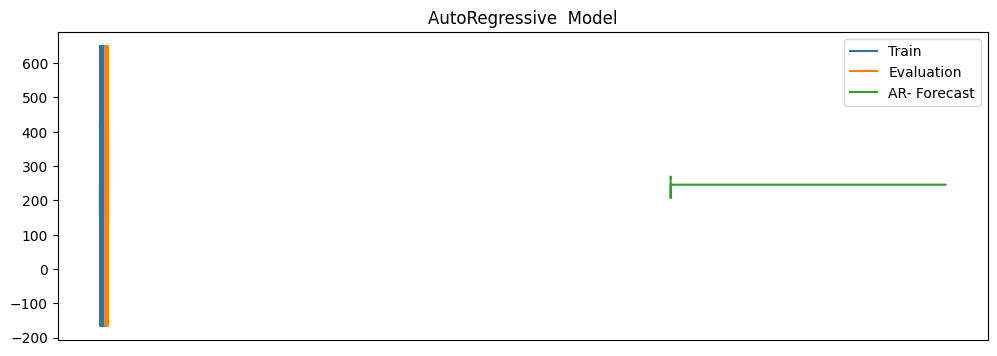

In [458]:

##Visualizing the prediction and the initial values
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales($)'],label = 'Train')
plt.plot(validation_data['Sales($)'],label = 'Evaluation')
plt.plot(AR_pred,label = 'AR- Forecast')
plt.legend(loc ='best')
plt.title('AutoRegressive  Model')
# Set the X-axis labels to an empty list to keep it blank
plt.xticks([])
plt.show()

Calculating the errors on the forecasting

In [459]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(AR_pred.dtype)

float64
float64


In [460]:
# Ensure that 'Sales($)' column in validation_data is in the correct numerical format
validation_data['Sales($)'] = pd.to_numeric(validation_data['Sales($)'], errors='coerce')

# Convert 'Sales($)' column to float32
validation_data['Sales($)'] = validation_data['Sales($)'].astype('float32')

# Convert AR_pred to float32
AR_pred = AR_pred.astype('float32')

In [461]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(AR_pred.dtype)

float32
float32


In [462]:
# Compute the mean squared error
mse = mean_squared_error(validation_data['Sales($)'], AR_pred)


In [463]:
# Calculate MSE, MSLE, RMSE, and RMSLE
ar_mse = mean_squared_error(validation_data['Sales($)'], AR_pred)
#msle = mean_squared_log_error(validation_data['Sales($)'], ARIMA_pred)
ar_rmse = np.sqrt(mse).round(2)
#rmsle = np.sqrt(msle).round(2)
ar_mae = mean_absolute_error(validation_data['Sales($)'], AR_pred)

# Create a DataFrame to store the results
ar_results = pd.DataFrame([['AR', ar_mse,ar_mae, ar_rmse]],
                          columns=['Model', 'MSE','MAE' ,'RMSE'])

# Display the results
print(ar_results)

  Model           MSE       MAE        RMSE
0    AR  16643.861328  85.25486  129.009995


### Model 2 - AutoRegressive Integrated Moving Average - ARIMA
its a versatile and widely used time series forecasting model that considers auto-regression, differencing, and moving averages to make predictions based on historical data. It's valuable for understanding and predicting patterns in time series data across various domains.

In [464]:
# Define your ARIMA order (p, d, q)
p = 1  # AutoRegressive (AR) order
d = 1  # Integrated (I) order (for differencing)
q = 1  # Moving Average (MA) order

# Create and train the model
arima_model = sm.tsa.ARIMA(y_train, order=(p, d, q))
arima_model_fit = arima_model.fit()
trained_models.append(arima_model_fit)

- Evaluating the model

In [465]:
#Predicting the Sales values
ARIMA_pred = arima_model_fit.predict(start = len(y_train),
end = len(y_train) + len(y_validation) -1)

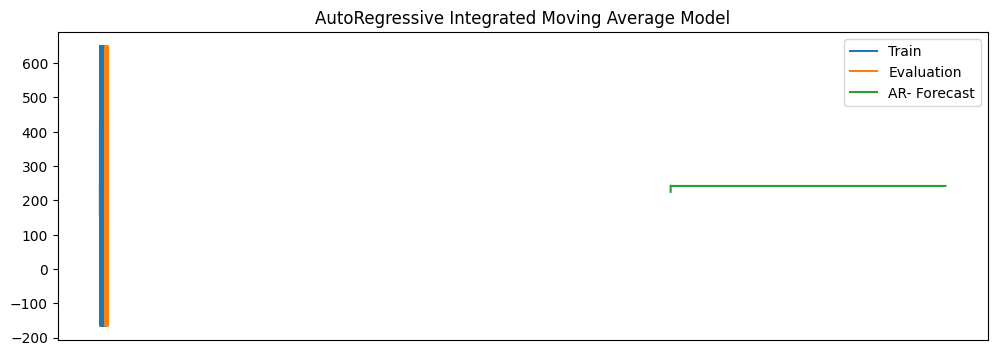

In [466]:
##Visualizing the prediction and the initial values
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales($)'],label = 'Train')
plt.plot(validation_data['Sales($)'],label = 'Evaluation')
plt.plot(ARIMA_pred,label = 'AR- Forecast')
plt.legend(loc ='best')
plt.title('AutoRegressive Integrated Moving Average Model')
# Set the X-axis labels to an empty list to keep it blank
plt.xticks([])
plt.show()

Calculating the errors on the forecasting

In [467]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(ARIMA_pred.dtype)

float32
float64


In [468]:
#'Sales($)' column in validation_data is in the correct numerical format
validation_data['Sales($)'] = pd.to_numeric(validation_data['Sales($)'], errors='coerce')

# Convert 'Sales($)' column to float32
validation_data['Sales($)'] = validation_data['Sales($)'].astype('float32')

# Convert AR_pred to float32
ARIMA_pred = ARIMA_pred.astype('float32')

In [469]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(ARIMA_pred.dtype)

float32
float32


In [470]:
# Calculate MSE, MSLE, RMSE, and RMSLE
arima_mse = mean_squared_error(validation_data['Sales($)'], ARIMA_pred)
#msle = mean_squared_log_error(validation_data['Sales($)'], ARIMA_pred)
arima_rmse = np.sqrt(mse).round(2)
#rmsle = np.sqrt(msle).round(2)
arima_mae = mean_absolute_error(validation_data['Sales($)'], AR_pred)

# Create a DataFrame to store the results
arima_results = pd.DataFrame([['ARIMA', arima_mse,arima_mae, arima_rmse]],
                          columns=['Model', 'MSE','MAE' ,'RMSE'])

# Display the results
print(arima_results)

   Model           MSE       MAE        RMSE
0  ARIMA  16643.349609  85.25486  129.009995


### MODEL 3. Linear Regression
Regression analysis using the simple linear model known as "linear regression" implies a linear relationship between the dependent and independent variables.


In [471]:
#build and train Linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# append to model trained list
trained_models.append(lr_model)

- Evaluating the model

In [472]:
#Predicting the Sales values
lr_pred = lr_model.predict(X_validation)

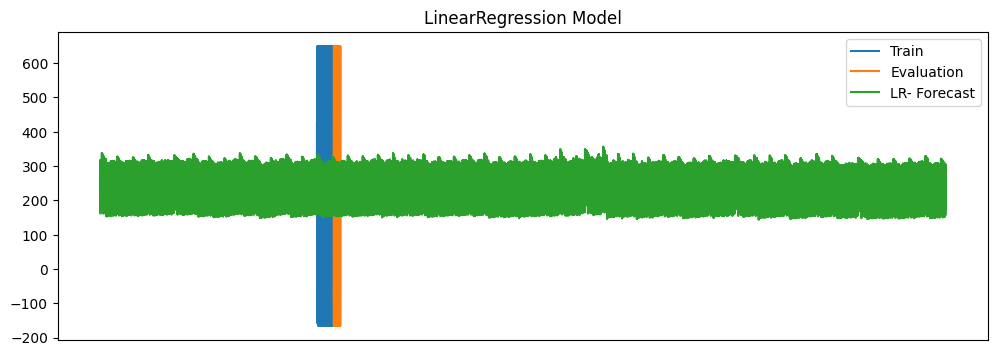

In [473]:
##Visualizing the prediction and the initial values
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales($)'],label = 'Train')
plt.plot(validation_data['Sales($)'],label = 'Evaluation')
plt.plot(lr_pred,label = 'LR- Forecast')
plt.legend(loc ='best')
plt.title('LinearRegression Model')
# Set the X-axis labels to an empty list to keep it blank
plt.xticks([])
plt.show()

Calculating the errors on the forecasting

In [474]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(lr_pred.dtype)

float32
float64


In [475]:
#'Sales($)' column in validation_data is in the correct numerical format
validation_data['Sales($)'] = pd.to_numeric(validation_data['Sales($)'], errors='coerce')

# Convert 'Sales($)' column to float32
validation_data['Sales($)'] = validation_data['Sales($)'].astype('float32')

# Convert AR_pred to float32
lr_pred = lr_pred.astype('float32')

In [476]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(lr_pred.dtype)

float32
float32


In [477]:
# Calculate MSE, MSLE, RMSE, and RMSLE
lr_mse = mean_squared_error(validation_data['Sales($)'], lr_pred)
#msle = mean_squared_log_error(validation_data['Sales($)'], lr_pred)
lr_rmse = np.sqrt(mse).round(2)
#rmsle = np.sqrt(msle).round(2)
lr_mae = mean_absolute_error(validation_data['Sales($)'], lr_pred)

# Create a DataFrame to store the results
lr_results = pd.DataFrame([['Linear R', lr_mse,lr_mae, lr_rmse]],
                          columns=['Model', 'MSE','MAE' ,'RMSE'])

# Display the results
print(lr_results)

      Model           MSE        MAE        RMSE
0  Linear R  14869.063477  81.545029  129.009995


### MODEL 4. Decision Tree Regressor Model
Using a tree structure to represent the relationships between the independent and dependent variables, the DecisionTree Regressor is a tree-based model that is especially effective at simulating nonlinear relationships.
 

In [478]:
#build and train  model
dt_reg_model = DecisionTreeRegressor()
dt_reg_model.fit(X_train, y_train)
# append to model trained list
trained_models.append(dt_reg_model)

In [479]:
#Predicting the Sales values
dt_pred = dt_reg_model.predict(X_validation)

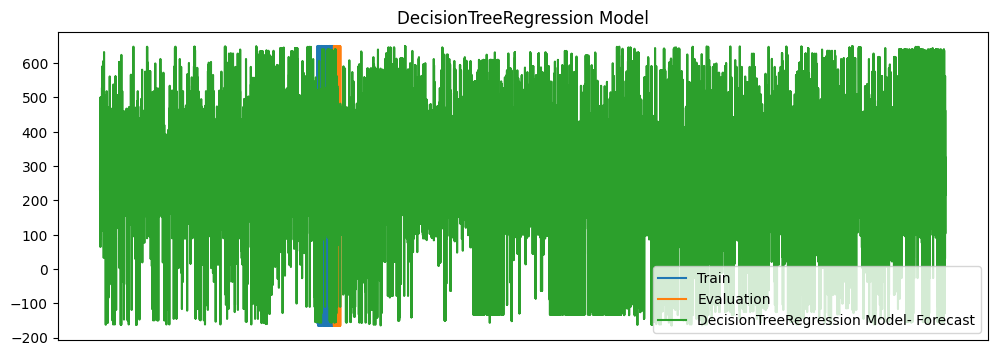

In [480]:
##Visualizing the prediction and the initial values
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales($)'],label = 'Train')
plt.plot(validation_data['Sales($)'],label = 'Evaluation')
plt.plot(dt_pred,label = 'DecisionTreeRegression Model- Forecast')
plt.legend(loc ='best')
plt.title('DecisionTreeRegression Model')
# Set the X-axis labels to an empty list to keep it blank
plt.xticks([])
plt.show()

Calculating the errors on the forecasting

In [481]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(lr_pred.dtype)

float32
float32


In [482]:
# Calculate MSE, MSLE, RMSE, and RMSLE
dt_mse = mean_squared_error(validation_data['Sales($)'], dt_pred)
#msle = mean_squared_log_error(validation_data['Sales($)'], lr_pred)
dt_rmse = np.sqrt(mse).round(2)
#rmsle = np.sqrt(msle).round(2)
dt_mae = mean_absolute_error(validation_data['Sales($)'], dt_pred)

# Create a DataFrame to store the results
dt_results = pd.DataFrame([['DecisionTreeRegressor', dt_mse,dt_mae, dt_rmse]],
                          columns=['Model', 'MSE','MAE' ,'RMSE'])

# Display the results
print(dt_results)

                   Model           MSE        MAE        RMSE
0  DecisionTreeRegressor  19749.776669  91.842487  129.009995


### Model 5 : XGBoost Regressor
Due to its great accuracy and speed, XGBRegressor is a gradient boosting solution that uses decision trees as the weak learners.

In [483]:
#build and train  model
xgb_reg_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_reg_model.fit(X_train, y_train)

# append to model trained list
trained_models.append(xgb_reg_model)

In [484]:
#Predicting the Sales values
xgb_pred = xgb_reg_model.predict(X_validation)

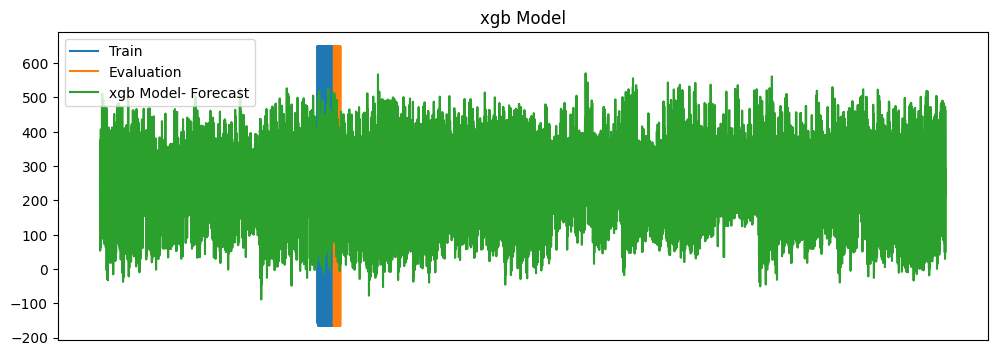

In [485]:
##Visualizing the prediction and the initial values
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales($)'],label = 'Train')
plt.plot(validation_data['Sales($)'],label = 'Evaluation')
plt.plot(xgb_pred,label = 'xgb Model- Forecast')
plt.legend(loc ='best')
plt.title('xgb Model')
# Set the X-axis labels to an empty list to keep it blank
plt.xticks([])
plt.show()

Calculating the errors on the forecasting

In [486]:
#check if the dtype of the AR VS validation
print(validation_data['Sales($)'].dtype)
print(xgb_pred.dtype)

float32
float32


In [487]:
# Calculate MSE, MSLE, RMSE, and RMSLE
xgb_mse = mean_squared_error(validation_data['Sales($)'], xgb_pred)
#msle = mean_squared_log_error(validation_data['Sales($)'], lr_pred)
xgb_rmse = np.sqrt(mse).round(2)
#rmsle = np.sqrt(msle).round(2)
xgb_mae = mean_absolute_error(validation_data['Sales($)'], xgb_pred)

# Create a DataFrame to store the results
xgb_results = pd.DataFrame([['XGB Regressor', xgb_mse,xgb_mae, xgb_rmse]],
                          columns=['Model', 'MSE','MAE' ,'RMSE'])

# Display the results
print(xgb_results)

           Model           MSE        MAE        RMSE
0  XGB Regressor  13556.384766  78.697121  129.009995


## 3.4 Model Comparison
Here going to compare the models using the  percentange errors(MSE,MAE,RMSE) in form of dataframe

In [488]:
# Create a results DataFrame
# Concatenate the individual DataFrames to create the final results DataFrame
results_df = pd.concat([ar_results, arima_results, lr_results, dt_results, xgb_results], ignore_index=True)

#changing range of validation for % calculation
y_validation_range = y_validation.max()-y_validation.min()

#calculate percentage errors
percentage_mse = (results_df['MSE']/y_validation_range)*100
percentage_rmse = (results_df['RMSE']/y_validation_range)*100
percentage_mae = (results_df['MAE']/y_validation_range)*100

# adding collumns of percentages
results_df['% MSE'] = percentage_mse
results_df['% RMSE'] = percentage_rmse
results_df['% MAE'] = percentage_mae
results_df

,Model,MSE,MAE,RMSE,% MSE,% RMSE,% MAE
0,AR,16643.861328,85.254860,129.009995,2038.901937,15.803948,10.443869
1,ARIMA,16643.349609,85.254860,129.009995,2038.839251,15.803948,10.443869
2,Linear R,14869.063477,81.545029,129.009995,1821.486116,15.803948,9.989408
3,DecisionTreeRegressor,19749.776669,91.842487,129.009995,2419.381964,15.803948,11.250864
4,XGB Regressor,13556.384766,78.697121,129.009995,1660.680693,15.803948,9.640534


The model XGB Regressor is the well performed and will be used in hyperparameter tuning stage for predictions. However the models are overfitting even after removing outliers

### 3.5 **Hyperparameter Tuning - XGB Regressor**
Here we are hypertuning the XGB Regressor for predictions. We are going to use gridsearch and Kfold to perform cross Validation

In [489]:
# Get the current hyperparameters
trained_models[4].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [490]:
# Define the parameter grid for hyperparameter tuning
parameters = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [4],
    'min_child_weight': [1],
    'gamma': [0.1],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'objective': ['reg:squarederror']
}

In [491]:
# Define the number of splits for cross-validation
n_splits = 5

# Initialize KFold with the number of splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create Grid Search with cross-validation
grid_search = GridSearchCV(estimator=trained_models[4], param_grid=parameters, 
                           scoring='neg_mean_squared_error', cv=kf, n_jobs=-1, verbose=1)

In [492]:
#fitting the train data with the gridsearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9], 'gamma': [0.1],
                         'learning_rate': [0.1], 'max_depth': [4],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [493]:
#the best parameters combination
grid_search.best_params_

{'colsample_bytree': 0.9,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [494]:
#Rename the best estimator per model intials
xgb_model = grid_search.best_estimator_
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [495]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.9}


In [496]:
# Get the best score for gridSearchCV tuning
best_xgb_score = grid_search.best_score_
print("Best XGB REGRESSOR Score after further improvement using GridSearchCV is:", best_xgb_score)

Best XGB REGRESSOR Score after further improvement using GridSearchCV is: -13684.131343004352


## 3.6 Future Predictions
Here we are going to predict future sales on our Final_Test dataset using our fine tuned model and create a submission file with forecasted sales

we are going to use the Model XGB Estimator where we  tuned hyperparameters using the GridSearch CV. Stored in the variable : **xgb** The best parameter combination was: **{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.9}**

In [497]:
#rechecking the test data
final_test.head(5)

,Store_nbr,Onpromotion,Daily Oil Price,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,Family_Others,Family_Personal Care,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
date,,,,,,,,,,,,,,,,,,,
2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,1.0,0.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,0.0,1.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,1,46.799999,0.0,0.0,0.0,0.0,0.0,1.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,1,46.799999,1.0,0.0,0.0,0.0,0.0,0.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,1.0,0.0,2017,8,16,2,228,0,0,0,0,0


Preprocess the test data add new features 
just like we did in train_data

In [499]:
final_test.head(5)

,Store_nbr,Onpromotion,Daily Oil Price,Family_Beverages,Family_Clothing,Family_Food,Family_Home and Kitchen,Family_Others,Family_Personal Care,year,month,day,weekday,day_of_year,is_start_month,is_end_month,is_start_year,is_end_year,is_weekend
date,,,,,,,,,,,,,,,,,,,
2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,1.0,0.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,0.0,1.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,1,46.799999,0.0,0.0,0.0,0.0,0.0,1.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,1,46.799999,1.0,0.0,0.0,0.0,0.0,0.0,2017,8,16,2,228,0,0,0,0,0
2017-08-16,1,0,46.799999,0.0,0.0,0.0,0.0,1.0,0.0,2017,8,16,2,228,0,0,0,0,0


In [504]:
train_data.columns

Index(['Store_nbr', 'Onpromotion', 'Sales($)', 'Daily Oil Price', 'Cluster',
       'Transferred', 'Transaction', 'Family_Beverages', 'Family_Clothing',
       'Family_Food', 'Family_Home and Kitchen', 'Family_Others',
       'Family_Personal Care', 'year', 'month', 'day', 'weekday',
       'day_of_year', 'is_start_month', 'is_end_month', 'is_start_year',
       'is_end_year', 'is_weekend'],
      dtype='object')

In [505]:
final_test.columns

Index(['Store_nbr', 'Onpromotion', 'Daily Oil Price', 'Family_Beverages',
       'Family_Clothing', 'Family_Food', 'Family_Home and Kitchen',
       'Family_Others', 'Family_Personal Care', 'year', 'month', 'day',
       'weekday', 'day_of_year', 'is_start_month', 'is_end_month',
       'is_start_year', 'is_end_year', 'is_weekend'],
      dtype='object')

In [498]:
#Predict the sales column using the XGB best estimator
y_test_pred = xgb_model.predict(final_test)

ValueError: feature_names mismatch: ['Store_nbr', 'Onpromotion', 'Daily Oil Price', 'Cluster', 'Transferred', 'Transaction', 'Family_Beverages', 'Family_Clothing', 'Family_Food', 'Family_Home and Kitchen', 'Family_Others', 'Family_Personal Care', 'year', 'month', 'day', 'weekday', 'day_of_year', 'is_start_month', 'is_end_month', 'is_start_year', 'is_end_year', 'is_weekend'] ['Store_nbr', 'Onpromotion', 'Daily Oil Price', 'Family_Beverages', 'Family_Clothing', 'Family_Food', 'Family_Home and Kitchen', 'Family_Others', 'Family_Personal Care', 'year', 'month', 'day', 'weekday', 'day_of_year', 'is_start_month', 'is_end_month', 'is_start_year', 'is_end_year', 'is_weekend']
expected Transaction, Transferred, Cluster in input data